Some code in this notebook has been adapted from the work of Zhongy et al. and Greydanus et al. and from the report and code of Jonas Perolini.

Their code is available in the following repositories :[
Symplectic-ODENet](https://github.com/Physics-aware-AI/Symplectic-ODENet) and [hamiltonian-nn](https://github.com/greydanus/hamiltonian-nn)

Structure inspired from https://github.com/Physics-aware-AI/Symplectic-ODENet/blob/master/experiment-single-force/data.py

# Imports & Setting up directories

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:  
    PATH = './' # './drive/MyDrive/1_SP_Ham_func/'
    from google.colab import drive
    drive.mount('/content/drive')

    %cd /content/drive/MyDrive/1_SP_Ham_func/
    %pip install torchdiffeq
else:
    import sys; sys.path.insert(0, '..') 
    import os


Mounted at /content/drive
/content/drive/MyDrive/1_SP_Ham_func


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split
import torch

from torch.optim.lr_scheduler import LinearLR

from torchdiffeq import odeint_adjoint as odeint_adjoint 
# func must be a nn.Module when using the adjoint method
from torchdiffeq import odeint as odeint

import time as time

# Code

## dynamics

In [3]:
def furuta_H(q1, p1, q2, p2, g, Jr, Lr, Mp, Lp):
    '''
    Description:
      Hamiltonian function for the Furuta pendulum 
    Inputs : 
      - q1,p1,q2,p2 (tensors) : Generalized coordinates 
    Outputs : 
      - H (tensor) : Hamiltonian function 
    Credits : 
      - Equations & constants are from Jonas's report
    ''' 

    # system constants
    Jp = (1/12)*Mp*Lp**2

    # function constants
    C1 = Jr + Mp*Lr**2
    C2 = (1/4)*Mp*Lp**2
    C3 = (-1/2)*Mp*Lp*Lr
    C4 = Jp+C2
    C5 = (1/2)*Mp*g*Lp

    # hamiltonian function
    H = p1**2 * (C1+C2*torch.sin(q1)**2 )+ C4*p2**2-2*p1*p2*C3*torch.cos(q1)
    H = (1/2) * (H)/(C1*C4+C4*C2*torch.sin(q1)**2 - (C3**2) * (torch.cos(q1)**2)) 
    H = H + C5*(torch.cos(q1)+1)

    return H
    
def hamiltonian_fn_furuta(coords, g, Jr, Lr, Mp, Lp):
    '''
    Description:
      Hamiltonian function for the Furuta pendulum, wraps furuta_H so that it is 
      the right format for ODEint

    Inputs : 
      - coords (tensor) : vector containing generalized coordinates q1,p1,q2,p2

    Outputs :
      - H (tensor) : Scalar Hamiltonian function

    Credits : 
      This function takes the same structure as the one in the SymODEN repository
    '''
    q1,p1,q2,p2 = torch.split(coords,1)

    H = furuta_H(q1, p1, q2, p2, g, Jr, Lr, Mp, Lp)
    return H

def coord_derivatives_furuta(t, coords, C_q1, C_q2, g, Jr, Lr, Mp, Lp, u_func, g_func):
    '''
    Description:
        Returns the derivatives of the generalized coordinates

    Inputs : 
      - coords (tensor) : vector containing generalized coordinates q1,p1,q2,p2
      - C_q1 (float) : coefficient of friction related to p1 ( and q1)
      - C_q2 (float) : coefficient of friction related to p2 ( and q2)

    Outputs :
      - dq1dt, dp1dt, dq2dt, dp2dt (tensors) : Derivatives w.r.t coords
    '''
    if coords.requires_grad is not True:
        coords.requires_grad=True

    # Hamiltonian function
    H = hamiltonian_fn_furuta(coords, g, Jr, Lr, Mp, Lp)

    # gradient of the hamiltornian function wrt the generalized coordinates
    dcoords = torch.autograd.grad(H, coords, create_graph=True) # !! might need to add H.sum() if batches used here later

    dHdq1, dHdp1, dHdq2, dHdp2 = torch.split(dcoords[0], 1)

    U = u_func.forward(t)
    G = g_func.forward(coords)

    dq1dt =   dHdp1 + U * G[0]
    dp1dt = - dHdq1 - C_q1*dHdp1 + U * G[1]
    dq2dt =   dHdp2 + U * G[2]
    dp2dt = - dHdq2 - C_q2*dHdp2 + U * G[3]

    return dq1dt, dp1dt, dq2dt, dp2dt
    
def dynamics_fn_furuta(t, coords, C_q1, C_q2, g, Jr, Lr, Mp, Lp, u_func, g_func):
    '''
    Description:
    Function that returns the gradient (in form of a function) of a Hamiltonian function
    Inputs : 
      - t () : 
      - coords () : generalized coordinates
      - u () : system input
      - C () : dissipation coefficient

    Outputs :
      - S () : Symplectic gradient

    Credits : 
      - This function has a similar structure as the one in the SymODEN repository
    '''

    dq1dt, dp1dt, dq2dt, dp2dt = coord_derivatives_furuta(t, coords, C_q1, C_q2, g, Jr, Lr, Mp, Lp, u_func, g_func)

    S = torch.hstack((dq1dt, dp1dt, dq2dt, dp2dt))
    return S

''' Input functions '''

def chirp_fun(t,T=1.5,f0=1,f1=50, scale =1):
    # https://en.wikipedia.org/wiki/Chirp
    c = (f1-f0)/T
    return torch.sin(2*torch.pi*(c*t**2/2 + f0*t))*scale

def multi_sine(t, scale = 0.5):
    f = torch.tensor([2,10,3,4], device = t.device).unsqueeze(dim=1)
    A = torch.tensor([2,0.5,0.3,0.8], device = t.device).unsqueeze(dim=1)
    return (A*torch.sin(2*torch.pi*t*f)).sum(dim=0)*scale

def step_fun(t, t1=0.05, scale=0.1):
    f = torch.zeros_like(t)
    f[t < t1] = 0
    f[~(t < t1)] = scale
    return f

class U_FUNC():
    def __init__(self, utype=None, params={}):
        super(U_FUNC).__init__()
        self.utype = utype
        self.params = params # dict containing params for the input function
        self.params['T'] = 1.5
        self.params['f0'] = 1
        self.params['f1'] = 10
        self.params['scale'] = 1

    def forward(self, t):  
        ''' time dependent input '''
        if self.utype == 'tanh':
            u = (-torch.tanh((t-0.75)*4)+1)/100
        elif self.utype == 'chirp':
            u = chirp_fun(t,
                            T=self.params['T'],
                            f0=self.params['f0'],
                            f1=self.params['f1'],
                            scale = self.params['scale'])
        elif self.utype == 'multisine':
            u = multi_sine(t, scale = self.params['scale'])
        elif self.utype == 'step':
            u = step_fun(t, t1=0.5)
        elif self.utype is None:
            u = torch.zeros(t.shape, device=t.device)
        u.requires_grad=False
        return u

class G_FUNC():
    def __init__(self, gtype=None, params={}):
        super(G_FUNC).__init__()
        self.gtype = gtype
        self.params = params # dict containing params on
        self.params['q_ref']= torch.tensor([1.0],device=device)
    
    def forward(self, coords): 
        ''' state dependent input '''
        q1,p1,q2,p2 = torch.split(coords,1,dim=-1)
        if self.gtype=='simple':
            if len(q1.shape)==1:
                dimension = 0
            else:
                dimension = 1
            g = torch.stack((torch.zeros(q1.shape[0],device = q1.device),
                             torch.ones(q1.shape[0],device = q1.device), # this is not a mistake, because we use (q1,p1,q2,p2) as convention
                             torch.zeros(q1.shape[0],device = q1.device),
                            torch.ones(q1.shape[0],device = q1.device)), dim=dimension)
        
        # if self.gtype=='setpoint':
        #     if len(q.shape)==1:
        #         dimension = 0
        #     else:
        #         dimension = 1
        #     g = torch.stack((torch.zeros(q.shape[0]),torch.ones(q.shape[0])*q-self.params['q_ref']), dim=dimension)

        elif self.gtype is None:
            g = torch.zeros(q1.shape[0], 4, device = q1.device)
        g.requires_grad = False
        return g

## trajectories

### single

In [4]:
def random_uniform_two_interval(init_method):
    '''
      return x taken from a uniform distribution in one of two intervals 
      [-2,-0.3] or [0.3,2]
    Input : 
      None
    Outputs : 

    '''
    if init_method == 'random_nozero':
        if torch.tensor([0.5]).bernoulli().bool():
            x = torch.zeros(1).uniform_(0.3, 2)
        else:
            x = torch.zeros(1).uniform_(-2,-0.3)
    elif init_method == 'random_closetozero':
            x = torch.zeros(1).uniform_(-0.3, 0.3)
    elif init_method == 'random_closetopi':
            x = torch.zeros(1).uniform_(torch.pi-0.3, torch.pi+0.3)
    return x


def get_init_state(init_method):
    '''
      Returns initial states q1,p1,q2,p2 for the Furuta pendulum 
      The angular velocities ( /generalized momenmtums) are set to zero
    Inputs : 
      None
    Outputs : 
      y0(tensor) : inital condition
      
    '''
    y0 = torch.zeros(4)

    y0[0] = random_uniform_two_interval(init_method) 
    y0[2] = torch.zeros(1).uniform_(2, 6) # random_uniform_two_interval() 

    y0[1]=0.0 # p1 = 0
    y0[3]=0.0 # p2 = 0
    return y0

'''Functions to generate the trajectories'''

def get_trajectory_furuta(device, init_method, u_func=None, g_func=None, time_steps=20, y0=None, noise_std=0.0, Ts = 0.005, C_q1=0.0, 
                          C_q2=0.0, g = 9.81, Jr = 5.72*1e-5, Lr = 0.085, Mp = 0.024, Lp = 0.129):   
    '''
    Description:

    Inputs:

    Outputs:
      
    '''

     # sampling time

    t_eval = torch.linspace(1, time_steps, time_steps, device=device) * Ts # evaluated times vector
    t_span = [Ts, time_steps*Ts] # [t_start, t_end]

    # get initial state
    if y0 is None:
        y0 = get_init_state(init_method)
        y0 = y0.to(device) 

    # solve the differential equation using odeint
    q_p = odeint(func=lambda t, coords: dynamics_fn_furuta(t, coords, C_q1, C_q2, g, Jr, Lr, Mp, Lp, u_func, g_func), 
                 y0=y0, t=t_eval, method='rk4', options=dict(step_size=Ts)) 

    q1, p1, q2, p2 = torch.chunk(q_p, 4, 1) 

    u = u_func.forward(t_eval)
    g = g_func.forward(q_p)

    # add noise 
    q1 = (q1+torch.randn(q1.shape, device=device)*noise_std).detach().squeeze()
    p1 = (p1+torch.randn(p1.shape, device=device)*noise_std*torch.max(p1)).detach().squeeze()
    q2 = (q2+torch.randn(q2.shape, device=device)*noise_std).detach().squeeze()
    p2 = (p2+torch.randn(p2.shape, device=device)*noise_std*torch.max(p2)).detach().squeeze()

    # .detach() because the pytorch computational graph is no longer needed
    # only the value is needed
    # .squeeze() to have a desired dimentionality
    # *torch.max(p) otherwise noise is too big compared to the generalized momentum

    return u, g, q1, p1, q2, p2, t_eval.detach()

### energy

In [5]:
''' ENERGY functions '''

def energy_furuta(dq1dt, dq2dt, q1, g, Jr, Lr, Mp, Lp):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # system constants
    Jp = (1/12)*Mp*Lp**2

    # function constants
    C1 = Jr + Mp*Lr**2
    C2 = (1/4)*Mp*Lp**2
    C3 = (-1/2)*Mp*Lp*Lr
    C4 = Jp+C2
    C5 = (1/2)*Mp*g*Lp
    
    E = (1/2)* dq2dt**2 * (C1+C2*torch.sin(q1)**2)+ dq2dt*dq1dt*C3*torch.cos(q1)
    E = E +(1/2)*dq1dt**2 *C4+C5*torch.cos(q1)+C5

    return E

def get_energy_furuta(device, time_steps, Ts, u_func, g_func, q1, p1, q2, p2, C_q1, C_q2, g, Jr, Lr, Mp, Lp):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    energy=[]
    derivatives=[]
    t = torch.linspace(1, time_steps, time_steps, device=device) * Ts
    #for t, coords in (t, torch.stack((q1, p1, q2, p2),dim=1)):
    coords = torch.stack((q1, p1, q2, p2),dim=1)
    for i in range(len(t)):

      dq1dt, dp1dt, dq2dt, dp2dt = coord_derivatives_furuta(t[i], coords[i,:],
                                                            C_q1, C_q2, g, Jr, Lr, Mp, Lp,u_func, g_func)

      q1_n = coords[i,0]
      energy.append(energy_furuta(dq1dt,dq2dt,q1_n, g, Jr, Lr, Mp, Lp))
      derivatives.append(torch.hstack((dq1dt, dp1dt, dq2dt, dp2dt)))
 
    energy = torch.hstack(energy).detach()
    derivatives = torch.vstack(derivatives).detach()
    return energy, derivatives

def get_energy_furuta_newtonian(q1, dq1dt, q2, dq2dt, C_q1, C_q2, g, Jr, Lr, Mp, Lp):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    energy=[]
    derivatives=[]
    for coords in torch.stack((q1, dq1dt, dq2dt),dim=1):

      q1_n = coords[0]
      dq1dt = coords[1]
      dq2dt = coords[2]
      energy.append(energy_furuta(dq1dt,dq2dt,q1_n, g, Jr, Lr, Mp, Lp))

    energy = torch.hstack(energy).detach()
    return energy

### multiple trajectories

In [6]:
''' MULTIPLE TRAJECTORIES '''

def multiple_trajectories_furuta(device,init_method, time_steps, num_trajectories, u_func=None, g_func=None, 
                          y0=torch.tensor([1.0,0.0,1.0,0.0]), Ts = 0.005,
                          noise_std=0.0, C_q1=0.0, C_q2=0.0, g = 9.81, 
                          Jr = 5.72*1e-5, Lr = 0.085, Mp = 0.024, Lp = 0.129, energ_deriv=True):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # the first trajectory
    u, G, q1, p1, q2, p2, t_eval = get_trajectory_furuta(device, init_method, u_func, g_func, time_steps, y0, noise_std, 
                                                   Ts, C_q1, C_q2, g, Jr, Lr, 
                                                   Mp , Lp)
    energy = []
    derivatives = []
    G = G.unsqueeze(dim=0)
    if energ_deriv:
      energy, derivatives = get_energy_furuta(device,time_steps, Ts, u_func, g_func, q1, p1, q2, p2, C_q1, C_q2, g, Jr, Lr, Mp, Lp)
      derivatives = derivatives.unsqueeze(dim=0)


    for _ in range(num_trajectories-1):
        # the trajectories 2 to num_trajectories
        u_n, G_n, q1_n, p1_n, q2_n, p2_n, t_eval_n = get_trajectory_furuta(device, init_method, u_func, g_func, time_steps, 
                                                                 y0, noise_std, 
                                                                Ts, C_q1, C_q2, g, Jr, Lr, 
                                                                Mp , Lp)
        energy_n, derivatives_n = get_energy_furuta(device, time_steps, Ts, u_func, g_func, q1_n, p1_n, q2_n, p2_n, C_q1, C_q2, g, Jr, Lr, Mp, Lp)

        q1 = torch.vstack((q1, q1_n))
        p1 = torch.vstack((p1, p1_n))
        q2 = torch.vstack((q2, q2_n))
        p2 = torch.vstack((p2, p2_n))
        u = torch.vstack((u, u_n))
        G  = torch.vstack((G, G_n.unsqueeze(dim=0)))

        if energ_deriv:
            energy = torch.vstack((energy, energy_n))
            derivatives  = torch.vstack((derivatives, derivatives_n.unsqueeze(dim=0)))
        # t_eval = torch.vstack((t_eval, t_eval_n))
      
    if num_trajectories == 1 :
        # so that the vectors will have the correct dimensions if only 1
        # trajectory is requested
        q1 = q1.unsqueeze(dim=0)
        p1 = p1.unsqueeze(dim=0)
        q2 = q2.unsqueeze(dim=0)
        p2 = p2.unsqueeze(dim=0)
        u = u.unsqueeze(dim=0)
        if energ_deriv:
          energy = energy.unsqueeze(dim=0)

        # t_eval = t_eval.unsqueeze(dim=0)

    return u, G, q1, p1, q2, p2, energy, derivatives, t_eval

## dataset & dataloader

In [7]:
class TrajectoryDataset_furuta(Dataset):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    def __init__(self, u, G, q1, p1, q2, p2, t_eval, #energy=torch.tensor(False), 
                 derivatives, coord_type='hamiltonian' ):
        self.t_eval = t_eval
        self.coord_type = coord_type
        self.q1 = q1 # [num_trajectories, time_steps]
        self.p1 = p1 # [num_trajectories, time_steps]
        self.q2 = q2 # [num_trajectories, time_steps]
        self.p2 = p2 # [num_trajectories, time_steps]
        self.u = u # [num_trajectories, time_steps]
        self.G = G # [num_trajectories, time_steps, (g1,g2,g3,g4)]

        self.dq1dt = derivatives[:,:,0] # [num_trajectories, time_steps, (dq1/dt,dp1/dt,dq2/dt,dp2/dt)]
        self.dq2dt = derivatives[:,:,2]

        
    def __len__(self):
        return len(self.q1)

    def __getitem__(self, idx):
        
        if self.coord_type == 'hamiltonian':

            q1 = self.q1[idx]
            p1 = self.p1[idx]
            q2 = self.q2[idx]
            p2 = self.p2[idx]
            u = self.u[idx]
            G = self.G[idx]
            x = torch.stack((q1,p1,q2,p2,u),dim=1)
            x = torch.hstack((x,G))
            
        if self.coord_type == 'newtonian':

            q1 = self.q1[idx]
            q2 = self.q2[idx]
            dq1dt = self.dq1dt[idx]
            dq2dt = self.dq2dt[idx]
            
            x = torch.vstack((q1,dq1dt,q2,dq2dt))
            
        t_eval = self.t_eval

        return x, t_eval



def data_loader_furuta(u, G, q1, p1, q2, p2, energy, derivatives, t_eval, batch_size,
                       shuffle = True, proportion = 0.5, coord_type='hamiltonian'):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # split  into train and test 
    full_dataset = TrajectoryDataset_furuta(u, G, q1, p1, q2, p2, t_eval,derivatives, coord_type=coord_type)
    if proportion:

        train_size = int(proportion * len(full_dataset))
        test_size = len(full_dataset) - train_size

        train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
        
        test_loader = DataLoader(
            test_dataset,
            batch_size,
            shuffle
            )    
    else:
      # if proportion is set to None don't split the dataset
        train_dataset = full_dataset
        energy_train = energy
        derivatives_train = derivatives
        t_eval_train = t_eval
        test_loader = None

    # create the dataloader object from the custom dataset
    train_loader = DataLoader(
        train_dataset,
        batch_size,
        shuffle
        )
       
    return train_loader, test_loader

## models

### base model

In [8]:
def choose_nonlinearity(name):
    '''
    From the SymODEN repository

    Description:

    Inputs:

    Outpus:
      
    '''
    nl = None
    if name == 'tanh':
        nl = torch.tanh
    elif name == 'x+sin(x)^2':
        nl = lambda x: x + torch.sin(x).pow(2)
    else:
        raise ValueError("nonlinearity not recognized")
    return nl

class hidden_Layer(torch.nn.Module):
    '''
    Fully connected layer with activation function
    '''
    def __init__(self,hidden_dim, activation='tanh'):
        super().__init__()
        self.fc = torch.nn.Linear(hidden_dim,hidden_dim)
        self.activation = choose_nonlinearity(activation)# activation function

    def forward(self, x):
        x=self.activation(self.fc(x))
        return x


class MLP(torch.nn.Module):
    '''
    MLP with number of hidden layers as a parameter
    '''
    def __init__(self, input_dim=2, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='x+sin(x)^2'):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = torch.nn.Sequential(
            *(hidden_Layer(hidden_dim, activation)
              for _ in range(nb_hidden_layers))
        ) # trick from EE-559 to define hidden layers
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)
        self.activation = choose_nonlinearity(activation) # activation function

    def forward(self, x):
        h = self.activation( self.fc1(x) )
        h = self.hidden_layers(h) 
        return self.fc2(h)

### simple mlp

In [9]:
class Simple_MLP(torch.nn.Module):
    '''
    Modified version of the original SymODEN_R module from symoden repository
    Similar to unconstrained ODE HNN from the report

    '''
    def __init__(self, input_dim, H_net=None, device=None):
        super(Simple_MLP, self).__init__()
        self.H_net = H_net

        self.device = device
        self.input_dim = input_dim
        
        # add learnable dissipation coefficients
        self.C1_dissip = torch.nn.Parameter(torch.tensor([0.02]).sqrt()) # torch.nn.Parameter(torch.randn(1)+1) # torch.nn.Parameter(torch.tensor([0.5])) 
        self.C1_dissip.requires_grad = True
        self.C2_dissip = torch.nn.Parameter(torch.tensor([0.02]).sqrt()) # torch.nn.Parameter(torch.randn(1)+1) # torch.nn.Parameter(torch.tensor([0.5])) 
        self.C2_dissip.requires_grad = True

    def forward(self, t, x):
        with torch.enable_grad():
            q_p = x

            # q1,p1,q2,p2 = torch.chunk(x,4,dim=-1)

            q_p.requires_grad_(True)

            H = self.H_net(q_p)

            # .sum() to sum up the hamiltonian funcs of a batch
            dH = torch.autograd.grad(H.sum(), q_p, create_graph=True)

            dH = dH[0]

            dHdq1 , dHdp1, dHdq2 , dHdp2 = torch.chunk(dH,4,dim=-1)

            dq1dt = dHdp1
            dp1dt = -dHdq1 - self.C1_dissip.pow(2)*dHdp1
            dq2dt = dHdp2
            dp2dt = -dHdq2 - self.C2_dissip.pow(2)*dHdp2

            # symplectic gradient 
            S_h = torch.cat((dq1dt, dp1dt, dq2dt, dp2dt), 
                            dim=-1) 

            return S_h


### autoencoder

In [10]:
class Autoencoder(torch.nn.Module):
    '''
    '''
    def __init__(self, nb_hidden_layers=1,  hidden_dim=64, activation='tanh', config = 'latent'):
        super(Autoencoder, self).__init__()
        
        self.config = config
        if self.config == 'latent':
                enc_in_dim = 4
                enc_out_dim = 2
                dec_in_dim = 4
                dec_out_dim = 4

        elif self.config == 'encoded':
                enc_in_dim = 4
                enc_out_dim = 4
                dec_in_dim = 4
                dec_out_dim = 4

        self.encoder = MLP(input_dim=enc_in_dim, hidden_dim=hidden_dim, 
                           nb_hidden_layers=nb_hidden_layers, output_dim=enc_out_dim, activation=activation)
        
        self.decoder = MLP(input_dim=dec_in_dim, hidden_dim=hidden_dim, 
                           nb_hidden_layers=nb_hidden_layers, output_dim=dec_out_dim, activation=activation)

    def forward(self, x): # x is (q, q_dot)

        if self.config == 'latent':
                q1, p1, q2, p2 = torch.split(x,1,dim=-1)

                p_hat = self.encoder(x) # coordinates in the latent space

                z = torch.stack((q1[:,:,0],p_hat[:,:,0],q2[:,:,0],p_hat[:,:,1]),dim=2) # input known q and encoded z into decoder
                
                x_hat = self.decoder(z) # coordinates back in the original space but using the decoder

                # x_hat = torch.stack((q1[:,:,0],q_dot_hat[:,:,0],q2[:,:,0],q_dot_hat[:,:,1]),dim=2)

                # x_hat = torch.stack((q1[:,:,0],q_dot_hat[:,:,0],q2[:,:,0],q_dot_hat[:,:,1]),dim=2)
        if self.config == 'encoded':
                z = self.encoder(x)
                x_hat = self.decoder(z)

        return z , x_hat

### Nes_HDNN

In [11]:
class Nes_HDNN(torch.nn.Module):
    '''
    Modified version of the original SymODEN_R module from symoden repository
    Similar to unconstrained ODE HNN from the report

    '''
    def __init__(self, u_func = None, G_net=None, H_net=None, device=None):
        super(Nes_HDNN, self).__init__()
        self.H_net = H_net
        self.G_net = G_net
        self.u_func = u_func
        self.device = device
        
        # add learnable dissipation coefficients
        self.C1_dissip = torch.nn.Parameter(torch.tensor([0.02]).sqrt()) # torch.nn.Parameter(torch.randn(1)+1) # torch.nn.Parameter(torch.tensor([0.5])) 
        self.C1_dissip.requires_grad = True
        self.C2_dissip = torch.nn.Parameter(torch.tensor([0.02]).sqrt()) # torch.nn.Parameter(torch.randn(1)+1) # torch.nn.Parameter(torch.tensor([0.5])) 
        self.C2_dissip.requires_grad = True

    def forward(self, t, x):
        with torch.enable_grad():
            q_p = x[:,:4]

            # q1,p1,q2,p2 = torch.chunk(x,4,dim=-1)

            q_p.requires_grad_(True)

            H = self.H_net(q_p)

            # .sum() to sum up the hamiltonian funcs of a batch
            dH = torch.autograd.grad(H.sum(), q_p, create_graph=True)

            dH = dH[0]

            dHdq1 , dHdp1, dHdq2 , dHdp2 = torch.chunk(dH,4,dim=-1)

            if self.G_net:
                G = self.G_net.forward(q_p)
                # print(G.device)
            else:
                G = x[:,5:]
            if self.u_func:
                u = self.u_func.forward(t)
                # print(u.device)
            else:
                u = x[:,4]
            # print('q_p',q_p.shape)
            # print('G',G.shape)
            # print('u',u.shape, u)
            # print('dHdq1',dHdq1.shape)
            dq1dt = dHdp1 
            dp1dt = -dHdq1 + (G[:,1].T*u).unsqueeze(dim=1) # - self.C1_dissip.pow(2)*dHdp1 
            dq2dt = dHdp2 
            dp2dt = -dHdq2 + (G[:,3].T*u).unsqueeze(dim=1) # - self.C2_dissip.pow(2)*dHdp2 

            # symplectic gradient 
            # zeros = torch.zeros_like(dq1dt)
            S_h = torch.cat((dq1dt, dp1dt, dq2dt, dp2dt), dim=-1) #, zeros, zeros, zeros, zeros, zeros
            return S_h

    def freeze_G_net(self, freeze=True): 
        """
        Only freez the G_net parameters
        Inputs
            freeze(bool) : True = freeze the parameters; False = don't
        
        outputs:
            None

        """
        for param in self.G_net.parameters(): 
            param.requires_grad = (not freeze)

    def freeze_H_net(self, freeze=True): 
        """
        Only freez the H_net parameters
        Inputs
            freeze(bool) : True = freeze the parameters; False = don't
      
        outputs:
            None
        """
        for param in self.H_net.parameters(): 
            param.requires_grad = (not freeze)

## plots

### for data

In [12]:
def plot_traj_furuta(t_eval, q1, p1, q2, p2, energy=torch.tensor(False),
                     title = 'Trajectory of the generalized coordinates', coord_type='hamiltonian'):
    '''
    This function plots the generalised variables q1, p1, q2, p2, and the energy 
    at the time t_eval at which they were evaluated
    Inputs:
      t_eval (tensor) : vector containing evaluation times of the generalized coordinates
      q1 (tensor) : generalized position q1
      p1 (tensor) : generalized momentum p1
      q2 (tensor) : generalized position q1
      p2 (tensor) : generalized momentum p2
      energy (tensor) : energy evaluated at the provided coordinates, if
          not provided, it will not appear in the plot (default = torch.tensor(False))
    Outputs:
      None
    '''
    # TODO : make this work for two columns
    if torch.any(energy):
        
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(15, 4),constrained_layout=True, sharex=True)# , sharey=True)
        ax5.plot(t_eval, energy, label='energy')

        # ax1.legend()
        ax5.set_title('Energy', fontsize=10)
        ax5.set_xlabel('time (s)')
        ax5.set_ylabel('E')
        ax5.set_ylim((0,torch.max(energy)*1.1))
    else:
       fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4),constrained_layout=True, sharex=True)# , sharey=True)


    ax1.plot(t_eval, q1, label='q1')
    ax2.plot(t_eval, p1, label='p1')
    ax3.plot(t_eval, q2, label='q2')
    ax4.plot(t_eval, p2, label='p2')

    #ax1.legend()
    ax1.set_title('generalized position (q1)', fontsize=10)
    ax1.set_xlabel('time[s]')
    ax1.set_ylabel('q1[rad]')

    #ax2.legend()
    ax2.set_title('generalized momentum (p1)', fontsize=10)
    ax2.set_xlabel('time [s]')
    ax2.set_ylabel('p1')

    ax3.set_title('generalized position (q2)', fontsize=10)
    ax3.set_xlabel('time [s]')
    ax3.set_ylabel('q2[rad]')

    ax4.set_title('generalized momentum (p2)', fontsize=10)
    ax4.set_xlabel('time [s]')
    ax4.set_ylabel('p2')
    
    if coord_type == 'newtonian':
        ax2.set_title(r'$\dot{q1}[rad/s]$', fontsize=10)
        ax2.set_ylabel(r'$\dot{q1}[rad/s]$')
        ax4.set_title(r'$\dot{q2}[rad/s]$', fontsize=10)
        ax4.set_ylabel(r'$\dot{q2}[rad/s]$')

    fig.suptitle(title, fontsize=12)
    plt.show()
    return

In [13]:
def plot_traj_furuta_withinput(t_eval, q1, p1, q2, p2, energy=torch.tensor(False), input=torch.tensor(False),
                     title = 'Trajectory of the generalized coordinates', coord_type='hamiltonian'):
    '''
    This function plots the generalised variables q1, p1, q2, p2, and the energy 
    at the time t_eval at which they were evaluated
    Inputs:
      t_eval (tensor) : vector containing evaluation times of the generalized coordinates
      q1 (tensor) : generalized position q1
      p1 (tensor) : generalized momentum p1
      q2 (tensor) : generalized position q1
      p2 (tensor) : generalized momentum p2
      energy (tensor) : energy evaluated at the provided coordinates, if
          not provided, it will not appear in the plot (default = torch.tensor(False))
    Outputs:
      None
    '''
    # TODO : make this work for two columns

    fig, ax = plt.subplots(2, 4,figsize=(15, 4),constrained_layout=True, sharex=True)# , sharey=True)
    if torch.any(energy):
      ax[1,0].plot(t_eval, energy, label='energy')
      ax[1,0].set_title('Energy', fontsize=10)
      ax[1,0].set_xlabel('time (s)')
      ax[1,0].set_ylabel('E')
      ax[1,0].set_ylim((0,torch.max(energy)*1.1))

    ax[1,1].plot(t_eval, input)
    ax[1,1].set_title('Input', fontsize=10)
    ax[1,1].set_xlabel('time (s)')
    ax[1,1].set_ylabel('U')

    ax[0,0].plot(t_eval, q1, label='q1')
    ax[0,0].set_title('generalized position (q1)', fontsize=10)
    ax[0,0].set_xlabel('time[s]')
    ax[0,0].set_ylabel('q1[rad]')

    ax[0,1].plot(t_eval, p1, label='p1')
    ax[0,1].set_title('generalized momentum (p1)', fontsize=10)
    ax[0,1].set_xlabel('time [s]')
    ax[0,1].set_ylabel('p1')

    ax[0,2].plot(t_eval, q2, label='q2')
    ax[0,2].set_title('generalized position (q2)', fontsize=10)
    ax[0,2].set_xlabel('time [s]')
    ax[0,2].set_ylabel('q2[rad]')

    ax[0,3].plot(t_eval, p2, label='p2')
    ax[0,3].set_title('generalized momentum (p2)', fontsize=10)
    ax[0,3].set_xlabel('time [s]')
    ax[0,3].set_ylabel('p2')
    
    if coord_type == 'newtonian':
        ax[0,2].set_title(r'$\dot{q1}[rad/s]$', fontsize=10)
        ax[0,2].set_ylabel(r'$\dot{q1}[rad/s]$')
        ax[0,4].set_title(r'$\dot{q2}[rad/s]$', fontsize=10)
        ax[0,4].set_ylabel(r'$\dot{q2}[rad/s]$')

    fig.suptitle(title, fontsize=12)
    plt.show()
    return

### for results

In [14]:
def plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t,n,t_max, C_q1, C_q2, g, Jr, Lr, Mp, Lp,
                        title = 'Trajectory of the generalized coordinates'#, coord_type='hamiltonian'
                     , file_path=None):
    '''
    Description:
      This function plots the generalised variables q p, the energy at the time
      t_eval at which they were evaluated
    Inputs:
      t_eval ()
      q ()
      p () 
    Outputs:
      None
    '''
    u, x_nom, t_eval = next(iter(data_loader_t))

    t_eval = t_eval[0,:] # otherwise it is by batch
    time_steps = len(t_eval)
    Ts = t_eval[0]
    # predicted trajectory
    x_hat = odeint(model, x_nom[:, :, 0], t_eval, method='rk4').detach()
    x_hat = x_hat.detach()

    q1_hat = x_hat[:,n,0] # to do: make this concise with torch split or chunck
    p1_hat = x_hat[:,n,1]
    q2_hat = x_hat[:,n,2]
    p2_hat = x_hat[:,n,3]

    E_hat, _ = get_energy_furuta(device, time_steps, Ts, u_func, g_func, utype, gtype, q1_hat, p1_hat, q2_hat, p2_hat, C_q1, C_q2, g, Jr, Lr, Mp, Lp)
    H_hat = furuta_H(q1_hat, p1_hat, q2_hat, p2_hat, g, Jr, Lr, Mp, Lp)
    # H_hat = model.H_net(x_hat[:,0,:]).detach().squeeze()

    # nominal trajectory
    q1_nom = x_nom[n,0,:]
    p1_nom = x_nom[n,1,:]
    q2_nom = x_nom[n,2,:]
    p2_nom = x_nom[n,3,:]

    E_nom, _ = get_energy_furuta(device, time_steps, Ts, u_func, g_func, utype, gtype, q1_nom, p1_nom, q2_nom, p2_nom, C_q1, C_q2, g, Jr, Lr, Mp, Lp)
    H_nom = furuta_H(q1_nom, p1_nom, q2_nom, p2_nom, g, Jr, Lr, Mp, Lp)

    


    fig, ax = plt.subplots(2, 3, figsize=(15, 4), constrained_layout=True, sharex=True)# , sharey=True)

    # to do : make a for loop to add multiple plots
    # predicted
    # plot nominal and predicted trajectory on same plot
    #

    # for x in [t_eval, q1_hat, p1_hat, q2_hat, p2_hat, E_hat, H_hat, q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom] :
    #     x = x.detach().cpu() # transfering everything to cpu memory
    #     print(x.device)
    t_eval = t_eval.cpu()


    for q1, p1, q2, p2, E, H, label in [[q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom,'nominal']]:
        q1 = q1.cpu() 
        p1 = p1.cpu() 
        q2 = q2.cpu() 
        p2 = p2.cpu() 
        E = E.cpu() 
        H = H.cpu() 
        
        ax[0,0].plot(t_eval, q1, label=label)
        ax[1,0].plot(t_eval, p1, label=label)
        ax[0,1].plot(t_eval, q2, label=label)
        ax[1,1].plot(t_eval, p2, label=label)
        ax[0,2].plot(t_eval, E, label=label)
        ax[1,2].plot(t_eval, H, label=label)



    for q1, p1, q2, p2, E, H, label in [[q1_hat, p1_hat, q2_hat, p2_hat, E_hat, H_hat,'prediction']]:
      
        q1 = q1.cpu() 
        p1 = p1.cpu() 
        q2 = q2.cpu() 
        p2 = p2.cpu() 
        E = E.cpu() 
        H = H.cpu() 
        ax[0,0].plot(t_eval[:t_max], q1[:t_max], label='train', c='g')
        ax[0,0].plot(t_eval[t_max-1:], q1[t_max-1:], label=label, c='r')

        ax[1,0].plot(t_eval[:t_max], p1[:t_max], label='train', c='g')
        ax[1,0].plot(t_eval[t_max-1:], p1[t_max-1:], label=label, c='r')

        ax[0,1].plot(t_eval[:t_max], q2[:t_max], label='train', c='g')
        ax[0,1].plot(t_eval[t_max-1:], q2[t_max-1:], label=label, c='r')

        ax[1,1].plot(t_eval[:t_max], p2[:t_max], label='train', c='g')
        ax[1,1].plot(t_eval[t_max-1:], p2[t_max-1:], label=label, c='r')

        ax[0,2].plot(t_eval[:t_max], E[:t_max], label='train', c='g')
        ax[0,2].plot(t_eval[t_max-1:], E[t_max-1:], label=label, c='r')

        ax[1,2].plot(t_eval[:t_max], H[:t_max], label='train', c='g')
        ax[1,2].plot(t_eval[t_max-1:], H[t_max-1:], label=label, c='r')






    # for j in range(3): # show all of the legends
    #   for i in range(2):
    
    ax[0,0].legend()

    # add labels and titles on every plot
    ax[0,0].set_title('generalized position (q1)', fontsize=10)
    ax[0,0].set_xlabel('time[s]')
    ax[0,0].set_ylabel('q1[rad]')

    ax[1,0].set_title('generalized momentum (p1)', fontsize=10)
    ax[1,0].set_xlabel('time [s]')
    ax[1,0].set_ylabel('p1')

    ax[0,1].set_title('generalized position (q2)', fontsize=10)
    ax[0,1].set_xlabel('time [s]')
    ax[0,1].set_ylabel('q2[rad]')

    ax[1,1].set_title('generalized momentum (p2)', fontsize=10)
    ax[1,1].set_xlabel('time [s]')
    ax[1,1].set_ylabel('p2')

    ax[0,2].set_title('Energy', fontsize=10)
    ax[0,2].set_xlabel('time (s)')
    ax[0,2].set_ylabel('E')
    #ax[0,2].set_ylim(bottom=0)
    #ax[0,2].set_ylim(0,torch.max(torch.cat((E_hat.cpu() ,E_nom.cpu())))*1.1) # because sometimes it won't appear on the plot

    ax[1,2].set_title('Hamiltonian', fontsize=10)
    ax[1,2].set_xlabel('time (s)')
    ax[1,2].set_ylabel('H')

    # add larger title on top
    fig.suptitle(title, fontsize=12)

    if file_path is not None:
        plt.savefig(file_path, format="png",dpi=400)#,bbox_inches='tight') # dpi
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()
    return

def plot_longer_horizon_furuta(device, model, u_func, g_func, utype, gtype, test_loader, t1, t2, C_q1, C_q2, g, Jr, Lr, Mp, Lp, 
                               title = 'Trajectory after longer horizon', file_path=None,):
    '''

    Description:

    Inputs:

    Outpus:
      
    '''
    u, x_nom, t_eval = next(iter(test_loader))

    t_eval = t_eval[0,t1:t2]

    time_steps = len(t_eval)
    Ts = t_eval[0]

    # test trajectories
    x_hat = odeint(model, x_nom[:, :, 0], t_eval, method='rk4').detach()
    x_hat = x_hat.detach()

    q1_hat = x_hat[t1:t2,0,0] # to do: make this concise with torch split or chunck
    p1_hat = x_hat[t1:t2,0,1]
    q2_hat = x_hat[t1:t2,0,2]
    p2_hat = x_hat[t1:t2,0,3]

    E_hat, _ = get_energy_furuta(device, time_steps, Ts, u_func, g_func, utype, gtype, q1_hat, p1_hat, q2_hat, p2_hat, C_q1, C_q2, g, Jr, Lr, Mp, Lp) 
    H_hat = furuta_H(q1_hat, p1_hat, q2_hat, p2_hat, g, Jr, Lr, Mp, Lp)
    # H_hat = model.H_net(x_hat[t1:t2,0,:]).detach().squeeze()

    # nominal trajectories
    q1_nom = x_nom[0,0,t1:t2]
    p1_nom = x_nom[0,1,t1:t2]
    q2_nom = x_nom[0,2,t1:t2]
    p2_nom = x_nom[0,3,t1:t2]

    E_nom, _ = get_energy_furuta(device, time_steps, Ts, u_func, g_func, utype, gtype, q1_nom, p1_nom, q2_nom, p2_nom, C_q1, C_q2, g, Jr, Lr, Mp, Lp)
    H_nom = furuta_H(q1_nom, p1_nom, q2_nom, p2_nom, g, Jr, Lr, Mp, Lp)


    fig, ax = plt.subplots(2, 2, figsize=(15, 6), constrained_layout=True, sharex=True)# , sharey=True)

    t_eval = t_eval.cpu()
    for q1, p1, q2, p2, E, H, label in [[q1_hat, p1_hat, q2_hat, p2_hat, E_hat, H_hat,'prediction'],[q1_nom, p1_nom, q2_nom, p2_nom, E_nom, H_nom,'nominal']]:
        
        q1 = q1.cpu() 
        p1 = p1.cpu() 
        q2 = q2.cpu() 
        p2 = p2.cpu() 
        E = E.cpu() 
        H = H.cpu() 
        
        ax[0,0].plot(t_eval, q1, label=label)
        ax[0,1].plot(t_eval, q2, label=label)

        ax[1,0].plot(t_eval, E, label=label)
        ax[1,0].set_title('Energy', fontsize=10)
        ax[1,0].set_xlabel('time (s)')
        ax[1,0].set_ylabel('E')
          
        ax[1,1].plot(t_eval, H, label=label)
        ax[1,1].set_title('Hamiltonian', fontsize=10)
        ax[1,1].set_xlabel('time (s)')
        ax[1,1].set_ylabel('H')

    #ax[1,0].set_ylim(0,torch.max(torch.cat((E_hat.cpu() ,E_nom.cpu())))*1.1) # because sometimes it won't appear on the plot

    # for j in range(2): # show all of the legends
    #   for i in range(2):
    #     ax[i,j].legend()
    ax[0,1].legend()

    # add labels and titles on every plot
    ax[0,0].set_title('generalized position (q1)', fontsize=10)
    ax[0,0].set_xlabel('time[s]')
    ax[0,0].set_ylabel('q1[rad]')

    ax[0,1].set_title('generalized position (q2)', fontsize=10)
    ax[0,1].set_xlabel('time [s]')
    ax[0,1].set_ylabel('q2[rad]')
    fig.suptitle(title, fontsize=12)
    if file_path is not None:
        plt.savefig(file_path, format="png",dpi=400)#,bbox_inches='tight') # dpi
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()
    return 

def train_test_loss_plot(loss_train,loss_test, epochs, file_path=None,
                            horizons = [100,150,200,250,300],
                            horizon_steps = [200,400,550,700,850],
                            title='train and test loss per epoch' ):
    ''' 
    Description:

    Inputs:

    Outpus:

    '''
    fig, ax = plt.subplots(figsize=(10,4))
    # ,constrained_layout=True)
    # fig.tight_layout()

    plt.plot(epochs, loss_train, label='train')

    if not loss_test == []: # if loss_test exists
        plt.plot(epochs[::10], loss_test, label='test')

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.legend()
    plt.title(title)

    if horizons:
        for i, epoch_num in enumerate(horizon_steps[:-1]):
            ax.annotate(
            'horizon = %d'%horizons[i],
            xy=(epochs[epoch_num], loss_train[epoch_num]), xycoords='data',
            xytext=(-70, 100), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            #connectionstyle="arc,angleA=0,armA=50,rad=10"
                            connectionstyle="angle,angleA=0,angleB=90,rad=10"
                            ))
        ax.annotate(
        'horizon = %d'%horizons[-1],
        xy=(epochs[horizon_steps[-1]], loss_train[horizon_steps[-1]]), xycoords='data',
        xytext=(+20, 100), textcoords='offset points',
        arrowprops=dict(arrowstyle="->",
                        #connectionstyle="arc,angleA=0,armA=50,rad=10"
                        connectionstyle="angle,angleA=0,angleB=90,rad=10"
                        ))

    if file_path is not None:
        plt.savefig(file_path, format="png",dpi=400)#,bbox_inches='tight') # dpi
        # plt.savefig(file_path, format="pdf", bbox_inches="tight")
    plt.show()
   
    return

### for training

In [15]:
def training_plot_old(t_eval, train_x, nominal_x):
    # train_x is [batch_size,(q1,p1,q2,p1),time_steps]
    # nominal_x is [time_steps, batch_size, (q1,p1,q2,p1)]

    fig, ax = plt.subplots(2, 2, figsize=(10, 5), constrained_layout=True, sharex=True)# , sharey=True)
    t_eval_cpu = t_eval.detach().cpu() 
    ax[0,0].plot(t_eval_cpu, train_x[:,0,0].detach().cpu(), label='train', c='g')
    ax[1,0].plot(t_eval_cpu, train_x[:,0,1].detach().cpu(), label='train', c='g')
    ax[0,1].plot(t_eval_cpu, train_x[:,0,2].detach().cpu(), label='train', c='g')
    ax[1,1].plot(t_eval_cpu, train_x[:,0,3].detach().cpu(), label='train', c='g')

    ax[0,0].plot(t_eval_cpu, nominal_x[0,0,:].detach().cpu(), label='nominal')
    ax[1,0].plot(t_eval_cpu, nominal_x[0,1,:].detach().cpu(), label='nominal')
    ax[0,1].plot(t_eval_cpu, nominal_x[0,2,:].detach().cpu(), label='nominal')
    ax[1,1].plot(t_eval_cpu, nominal_x[0,3,:].detach().cpu(), label='nominal')

    ax[0,0].set_title('generalized position (q1)', fontsize=10)
    ax[0,0].set_xlabel('time[s]')
    ax[0,0].set_ylabel('q1[rad]')

    ax[1,0].set_title('generalized momentum (p1)', fontsize=10)
    ax[1,0].set_xlabel('time [s]')
    ax[1,0].set_ylabel('p1')

    ax[0,1].set_title('generalized position (q2)', fontsize=10)
    ax[0,1].set_xlabel('time [s]')
    ax[0,1].set_ylabel('q2[rad]')

    ax[1,1].set_title('generalized momentum (p2)', fontsize=10)
    ax[1,1].set_xlabel('time [s]')
    ax[1,1].set_ylabel('p2')
    ax[1,1].legend()
    
    # add larger title on top
    fig.suptitle('intermediate plot of trajectories', fontsize=12)

    plt.show()
    return

In [16]:
def training_plot(t_eval, train_x, nominal_x):
    # train_x is [batch_size,(q1,p1,q2,p1),time_steps]
    # nominal_x is [time_steps, batch_size, (q1,p1,q2,p1)]

    fig, ax = plt.subplots(2, 2, figsize=(10, 5), constrained_layout=True, sharex=True)# , sharey=True)
    t_eval_cpu = t_eval.detach().cpu()
    # print('train_x',train_x.shape)#5 300 9
    # print('t_eval_cpu',t_eval_cpu.shape)#5 300 9
    # print('nominal_x',nominal_x.shape)#5 300 9

    ax[0,0].plot(t_eval_cpu, train_x[:,0,0].detach().cpu(), label='train', c='g')
    ax[1,0].plot(t_eval_cpu, train_x[:,0,1].detach().cpu(), label='train', c='g')
    ax[0,1].plot(t_eval_cpu, train_x[:,0,2].detach().cpu(), label='train', c='g')
    ax[1,1].plot(t_eval_cpu, train_x[:,0,3].detach().cpu(), label='train', c='g')
    # print(nominal_x.shape)
    ax[0,0].plot(t_eval_cpu, nominal_x[0,:,0].detach().cpu(), label='nominal')
    ax[1,0].plot(t_eval_cpu, nominal_x[0,:,1].detach().cpu(), label='nominal')
    ax[0,1].plot(t_eval_cpu, nominal_x[0,:,2].detach().cpu(), label='nominal')
    ax[1,1].plot(t_eval_cpu, nominal_x[0,:,3].detach().cpu(), label='nominal')

    ax[0,0].set_title('generalized position (q1)', fontsize=10)
    ax[0,0].set_xlabel('time[s]')
    ax[0,0].set_ylabel('q1[rad]')

    ax[1,0].set_title('generalized momentum (p1)', fontsize=10)
    ax[1,0].set_xlabel('time [s]')
    ax[1,0].set_ylabel('p1')

    ax[0,1].set_title('generalized position (q2)', fontsize=10)
    ax[0,1].set_xlabel('time [s]')
    ax[0,1].set_ylabel('q2[rad]')

    ax[1,1].set_title('generalized momentum (p2)', fontsize=10)
    ax[1,1].set_xlabel('time [s]')
    ax[1,1].set_ylabel('p2')
    ax[1,1].legend()
    
    # add larger title on top
    fig.suptitle('intermediate plot of trajectories', fontsize=12)

    plt.show()
    return

## utils

In [17]:
def set_device():
    # set device to GPU if available otherwise use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if device.type == 'cuda':
        # if there is a GPU
        print (f'Available device : {torch.cuda.get_device_name(0)}') 
    else :
        print(device)
    return device

def set_furuta_params(which = 'fake'):

    if which == 'fake':
        # The "fake" set of furuta parameters to have similar magnitudes in q1 p1 q2 p2
        Ts = 0.005
        noise_std = 0.0
        C_q1 = 0.0
        C_q2 = 0.0
        g = 9.81
        Jr = 1*1e-5
        Lr = 0.5
        Mp = 5.0
        Lp = 0.1

    if which == 'real':
        # The set of furuta parameters similar to the real furuta
        Ts = 0.005
        noise_std = 0.0
        C_q1 = 0.0
        C_q2 = 0.0
        g = 9.81
        Jr = 5.72*1e-5
        Lr = 0.085
        Mp = 0.024
        Lp = 0.129
    
    return Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp

def count_parameters(model):
    '''
    from https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/9
    Description:

    Inputs:

    Outpus:
      
    '''
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def load_model(device, hidden_dim=90, nb_hidden_layers=4):
    H_net = MLP(input_dim=4, hidden_dim=hidden_dim, nb_hidden_layers=nb_hidden_layers, output_dim=1, activation='x+sin(x)^2')
    model = Simple_MLP(input_dim=4, H_net=H_net, device=None) 
    model.to(device) 
    return model
    
def load_model_nes_hdnn(device, utype, u_func=None, hidden_dim=90, nb_hidden_layers=4):

    G_net = MLP(input_dim=4, hidden_dim=64, nb_hidden_layers=1, output_dim=2, activation='tanh')
    H_net = MLP(input_dim=4, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='x+sin(x)^2')
    model = Nes_HDNN(utype=utype, u_func=u_func, G_net=G_net, H_net=H_net, device=device)
    model.to(device)
    return model 
    
def load_data_device(device, init_method, u_func=None, g_func=None, time_steps=40, num_trajectories=10, shuffle = False,
                     coord_type='hamiltonian', proportion=0.5, batch_size=1, 
                     Ts = 0.005, noise_std=0.0, C_q1=0.0, C_q2=0.0, 
                     g = 9.81, Jr = 1*1e-5, Lr = 0.5, Mp = 5.0, Lp = 0.5):
    '''
    Description:

    Inputs:

    Outpus:
    '''
    # create trajectories
    u, G, q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta('cpu', init_method, time_steps, num_trajectories, u_func, g_func,
                          None, Ts , noise_std, C_q1, C_q2, g, Jr,  Lr,  Mp, Lp)

    q1 = q1.to(device)
    p1 = p1.to(device)
    q2 = q2.to(device)
    p2 = p2.to(device)
    energy = energy.to(device)
    derivatives = derivatives.to(device)
    t_eval = t_eval.to(device)
    u = u.to(device)
    G = G.to(device)
    # if u_func is not None:
    #     u = u_func(t_eval, utype).to(device)
    # else:
    #     u = torch.zeros_like(t_eval,device=device)
    # stds = torch.tensor([q1.std(),p1.std(),q2.std(),p2.std()])

    # dataloader to load data in batches
    train_loader, test_loader = data_loader_furuta(u, G, q1, p1, q2, p2, energy, derivatives, t_eval, batch_size=batch_size,
                          shuffle = shuffle, proportion = proportion, coord_type=coord_type)
    return train_loader, test_loader #, stds

def save_stats(PATH, stats, stats_path):
    with open(stats_path, 'w') as file:
        file.write(json.dumps(stats)) # use `json.loads` to do the reverse  
    return

def read_dict(PATH, stats_path):
    # read the stats txt file
    with open(stats_path) as f:
        data = f.read()

    data = json.loads(data)
    return data

## Train

### loss

In [18]:
def L2_loss(u, v, w = False, dim = (0,1), param = 'L2'):
    # u nominal
    # v approximate
    # u and v expected with shape : [time_steps, batch_size , (q1,p1,q2,p1)] 

    if param == 'L2weighted':
        # mean only over time steps and batch_size 
        loss = (((u-v)).pow(2)).mul(w).mean(dim = dim ).sum()
    elif param == 'L2':
        loss = (((u-v)).pow(2)).mean(dim = dim ).sum()
    elif param == 'L2weighted2':
        loss = (((u-v).mul(w)).pow(2)).mean(dim = dim ).sum()
    elif param == 'L2normalized':
        # formula : (u-v)/v
        # +1e-10 for stability in case of a zero # still not enough because loss on p1 explodes 
        # when nominal close to zero and predicted is far from zero
        loss = ((u.sub(v).div(u+1e-10)).pow(2)).mean(dim = dim ).sum()
    elif param == 'L2normalizedfixed':
        loss = ((u[:,:,:3].sub(v[:,:,:3]).div(u[:,:,:3]+1e-10)).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[:,:,3].sub(v[:,:,3])).pow(2)).mean(dim = dim ).sum()
    elif param == 'L2normalizedfixed2':
        # loss = ((u[1:,:,0].sub(v[1:,:,0]).div(u[1:,:,0]+1e-10)).mul(w[0]).pow(2)).mean(dim = dim ).sum()
        # loss = loss + ((u[1:,:,2].sub(v[1:,:,2]).div(u[1:,:,2]+1e-10)).mul(w[2]).pow(2)).mean(dim = dim ).sum()
        loss = ((u[1:,:,0].sub(v[1:,:,0]).div(w[0])).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,2].sub(v[1:,:,2]).div(w[2])).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,1].sub(v[1:,:,1]).div(w[1])).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,3].sub(v[1:,:,3]).div(w[3])).pow(2)).mean(dim = dim ).sum()

    elif param == 'L2normalizedfixed3':
        loss =        ((u[1:,:,0].sub(v[1:,:,0]).div(u[1:,:,0]+1e-5)).mul(w[0]).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,1].sub(v[1:,:,1]).mul(w[1])                     ).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,2].sub(v[1:,:,2]).div(u[1:,:,2]+1e-5)).mul(w[2]).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,3].sub(v[1:,:,3]).mul(w[3])                     ).pow(2)).mean(dim = dim ).sum()
        # loss = (1/4)*loss 

    elif param == 'L2normalizedfixed4': # division by std per trajectory bad some trajectory has tiny std that makes it explode
        std = u.std(dim=0)
        loss =        ((u[1:,:,0].sub(v[1:,:,0]).div(u[1:,:,0]+1e-10)).mul(w[0]).pow(2)).mean(dim = dim ).sum() 
        loss = loss + ((u[1:,:,1].sub(v[1:,:,1]).div(std[:,1]).mul(w[1])).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,2].sub(v[1:,:,2]).div(std[:,2]).mul(w[2])).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,3].sub(v[1:,:,3]).mul(w[3])).pow(2)).mean(dim = dim ).sum()

    elif param == 'L2normalizedfixed5':
        std = u.std(dim=0)
        loss =        ((u[1:,:,0].sub(v[1:,:,0]).div(std[:,0]).mul(w[0])).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,1].sub(v[1:,:,1]).div(std[:,1]).mul(w[1])).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,2].sub(v[1:,:,2]).div(std[:,2]).mul(w[2])).pow(2)).mean(dim = dim ).sum()
        loss = loss + ((u[1:,:,3].sub(v[1:,:,3]).mul(w[3])).pow(2)).mean(dim = dim ).sum()

    elif param == 'minmax': 
        std = u.std(dim=0)
        loss = 0
        for i in range(3):
            loss_t =  (u[1:,:,i].sub(v[1:,:,i])).mul(w[i])
            min = loss_t.min()
            max = loss_t.max()
            loss_t = (loss_t.div(max-min).pow(2)).mean(dim = dim ).sum()
            loss = loss + loss_t

        loss4 =  ((u[1:,:,3].sub(v[1:,:,3]).mul(w[3])).pow(2)).mean(dim = dim ).sum()  

    return loss

### horizon

In [19]:
def select_horizon_list(step, epoch_number, horizon_list = [50,100,150,200,250,300], switch_steps = [200,200,200,150,150,150]):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    # throw error if 
    assert len(horizon_list)==len(switch_steps), ' horizon_list and switch_steps must have same length'

    if step <=switch_steps[0]:
        horizon = horizon_list[0]
        if step==0:
            print('horizon length :', horizon)

    for i in range(len(switch_steps)):
      if (step > sum(switch_steps[0:i]))&(step <= sum(switch_steps[0:i+1])):
          horizon = horizon_list[i]
          if step==sum(switch_steps[0:i])+1:
              print('horizon length :', horizon)

    if step > sum(switch_steps):
        horizon = horizon_list[-1]
        if step== sum(switch_steps)+1:
            print('horizon length :', horizon)
    return horizon 

def select_horizon_wschedule(step,optim,epoch_number, 
                             switch_steps = (200,200,150,150,150)       
                            ):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    n1, n2, n3, n4, n5 = switch_steps
    # n1 number of steps with a horizon =  50
    # n2 number of steps with a horizon =  100
    # n3 number of steps with a horizon =  150
    # n4 number of steps with a horizon =  200
    # n5 number of steps with a horizon =  250
    # horizon = 300 for the remainder of training steps 

    if step <=n1:
        horizon = 50
        if step==0:
            print('horizon length :', horizon)
            # steps = n1
            # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
        num_steps = 0   
        do_step = False
            
    elif (step > n1)&(step <= n1+n2):
        horizon = 100
        if step==n1+1:
            print('horizon length :', horizon)
            # steps = n2
            # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
        num_steps = 0   
        do_step = False
    elif (step > n1+n2)&(step <= n1+n2+n3):
        horizon = 150
        if step==n1+n2+1:
            print('horizon length :', horizon)
            # steps = n3
            # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
        num_steps = 0   
        do_step = False
    elif (step > n1+n2+n3)&(step <= n1+n2+n3+n4):
        horizon = 200
        if step==n1+n2+n3+1:
            print('horizon length :', horizon)
            # steps = n4
            # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
        num_steps = 0     
        do_step = False
    elif (step > n1+n2+n3+n4)&(step <= n1+n2+n3+n4+n5):
        horizon = 250
        if step==n1+n2+n3+n4+1:
            print('horizon length :', horizon)
            # steps = n5
            # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, steps)
        num_steps = 0     
        do_step = False
    else :
        horizon = 300
        do_step = True
        num_steps = 0
        if step==n1+n2+n3+n4+n5+1:
            print('horizon length :', horizon)
            num_steps = epoch_number - (n1+n2+n3+n4+n5)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, num_steps)

    return horizon, num_steps

### train function

In [87]:
def train(model, Ts, train_loader, test_loader, w, grad_clip, lr_schedule, begin_decay, epoch_number, alternating=False, horizon=False, horizon_type=False,
          horizon_list = [50,100,150,200,250,300], 
          switch_steps = [200,200,200,150,150,150],
          epochs = 20, 
          loss_type = 'L2'):
    '''
    Description:

    Inputs:

    Outpus:
      
    '''
    ## TODO : make a function for one epoch
    ## first training steps on smaller amount of time_steps

    lr = 1e-3

    optim = torch.optim.AdamW(model.parameters(), lr, weight_decay=1e-4) # Adam
    if lr_schedule:
        scheduler = LinearLR(optim, start_factor=1.0, end_factor=0.5, total_iters=epochs-begin_decay)

    logs = {'train_loss': [], 'test_loss': []}
    # weight for loss function

    for step in range(epochs):
        
        train_loss = 0
        test_loss = 0
        t1 = time.time()

        if horizon_type == 'schedule':
            pass
        #     horizon, num_steps= select_horizon_wschedule(step,optim,
        #                                                   epoch_number,
        #                                                   switch_steps)
        #     if num_steps :
        #         scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, num_steps)
        elif horizon_type == 'auto': 
            horizon = select_horizon_list(step, epoch_number, horizon_list, switch_steps)

        model.train()
        for x, t_eval in iter(train_loader): 
            # x is [batch_size,time_steps,(q1,p1,q2,p1,u,g1,g2,g3,g4)]
            # print('xshape',x.shape)
            # print('tshape',t_eval.shape)
            t_eval = t_eval[0,:horizon]
            
            for i in range(2 if alternating else 1): # only runs once if alternating = False
                  if i==0 and alternating:
                      model.freeze_H_net(freeze=True)
                      model.freeze_G_net(freeze=False)
                  elif i==1 and alternating:
                      model.freeze_H_net(freeze=False)
                      model.freeze_G_net(freeze=True)

                  train_x_hat = odeint(model, x[:, 0, :4], t_eval, method='rk4', options=dict(step_size=Ts))     
                  # print('train_x_hat',train_x_hat.shape)       
                  # train_x_hat is [time_steps, batch_size, (q1,p1,q2,p1)] 

                  train_loss_mini = L2_loss(torch.permute(x[:, :horizon, :4], (1,0,2)) , train_x_hat[:,:,:4], w, param = loss_type)
                  # after permute x is [time_steps, batch_size, (q1,p1,q2,p1)]

                  # loss(u, v, w = False, dim = (0,1), param = loss_type)
                  if not step%10:
                      t_plot = time.time()
                      training_plot(t_eval, train_x_hat[:,:,:4], x[:, :horizon, :4])
                      print('plot time :' , time.time()-t_plot)

                  train_loss = train_loss + train_loss_mini.item()

                  train_loss_mini.backward() 
                  if grad_clip : # gradient clipping to a norm of 1
                      
                      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                  optim.step() 
                  optim.zero_grad()

                  if step>begin_decay:
                      scheduler.step()
                  
                  # if (horizon == 'schedule') and do_step:
                  #   scheduler.step()

        t2 = time.time()
        train_time = t2-t1

        model.eval()
        if test_loader: 
            with torch.no_grad(): # we won't need gradients for testing
                if not (step%10): # run validation every 10 steps
                    for x, t_eval in iter(test_loader):
                        # run test data
                        t_eval = t_eval[0,:horizon]
      
                        test_x_hat = odeint(model, x[:, 0, :4], t_eval, method='rk4', options=dict(step_size=Ts))      
                        #test_loss_mini = L2_loss(torch.permute(x[:, :, :horizon], (2,0,1)) , test_x_hat[:horizon,:,:],w)
                        test_loss_mini = L2_loss(torch.permute(x[:, :horizon, :4], (1,0,2)) , test_x_hat[:horizon,:,:4], w, param = loss_type)

                        test_loss = test_loss + test_loss_mini.item()
                    test_time = time.time()-t2
                    print('epoch {:4d} | train time {:.2f} | train loss {:8e} | test loss {:8e} | test time {:.2f}  '
                          .format(step, train_time, train_loss, test_loss,test_time))
                    logs['test_loss'].append(test_loss)
                    
                else:
                    print('epoch {:4d} | train time {:.2f} | train loss {:8e} '
                          .format(step, train_time, train_loss))
        else:
            print('epoch {:4d} | train time {:.2f} | train loss {:8e} '
                  .format(step, train_time, train_loss))
        
        # logging
        logs['train_loss'].append(train_loss)
    return logs

# Sanity checks

In [88]:
device = set_device()
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = 'fake')
utype = 'chirp'
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 1.4
u_func.params['scale'] = 0.1
gtype='simple'
g_func = G_FUNC(gtype=gtype)
init_method = 'random_closetopi' # 'random_nozero' # 'random_closetopi'
time_steps=300
num_trajectories = 10

cpu


In [89]:
u, G, q1, p1, q2, p2, t_eval = get_trajectory_furuta(device, init_method, u_func, g_func, time_steps, None, noise_std, Ts, C_q1, 
                          C_q2, g, Jr, Lr, Mp, Lp)

energy, _ = get_energy_furuta(device,time_steps, Ts, u_func, g_func, q1, p1, q2, p2, C_q1, C_q2, g, Jr, Lr, Mp, Lp)

In [61]:
u, G, q1, p1, q2, p2, energy, derivatives, t_eval = multiple_trajectories_furuta(device, init_method, time_steps, num_trajectories, u_func, g_func, 
                          None, Ts,
                          noise_std, C_q1, C_q2, g, 
                          Jr, Lr, Mp, Lp, energ_deriv=True)

In [57]:
print(u.shape)
print(G.shape)
print(q1.shape)
print(p1.shape)
print(q2.shape)
print(p2.shape)
print(t_eval.shape)

torch.Size([10, 300])
torch.Size([10, 300, 4])
torch.Size([10, 300])
torch.Size([10, 300])
torch.Size([10, 300])
torch.Size([10, 300])
torch.Size([300])


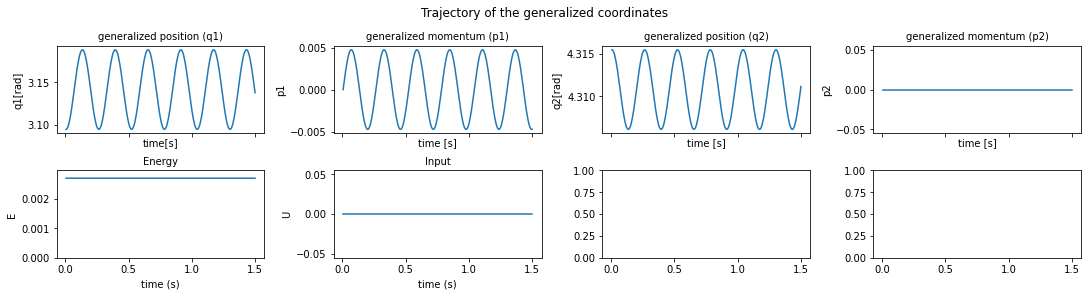

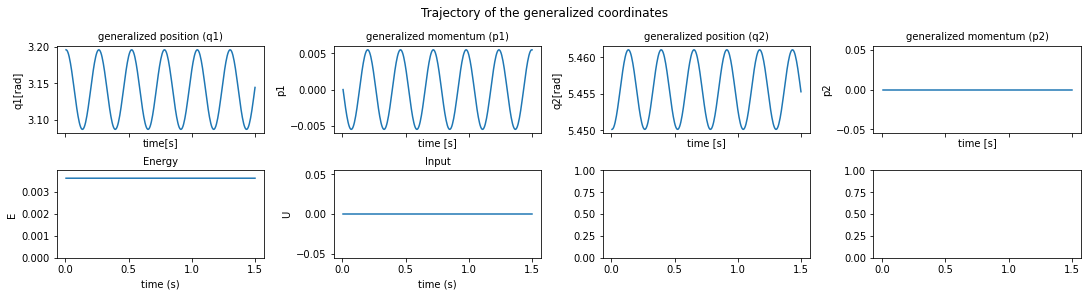

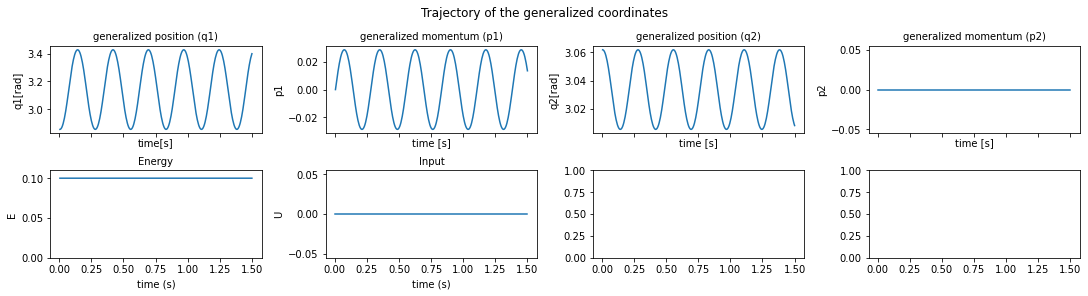

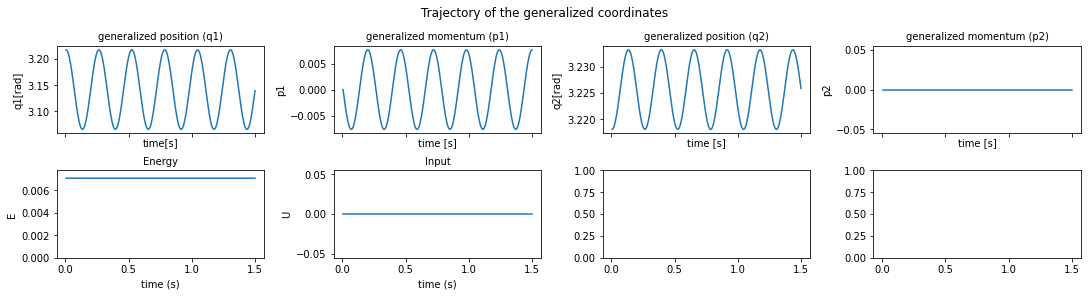

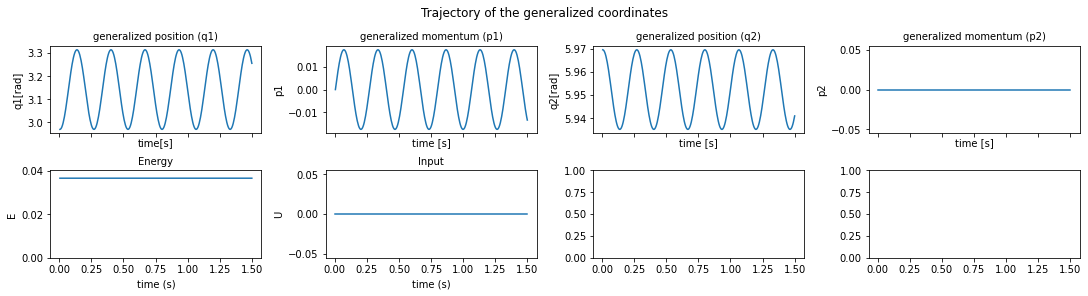

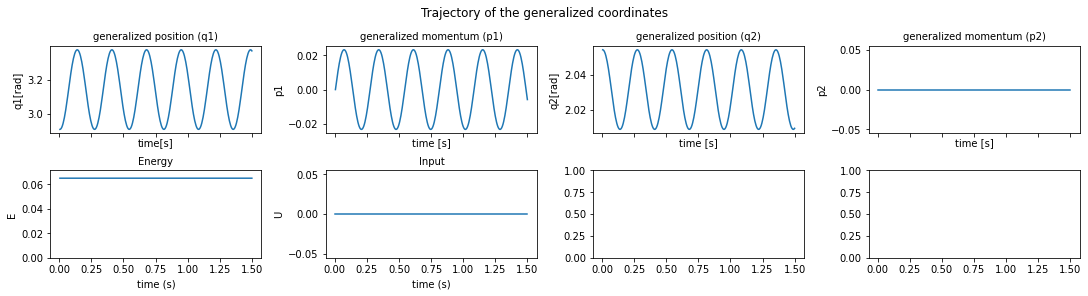

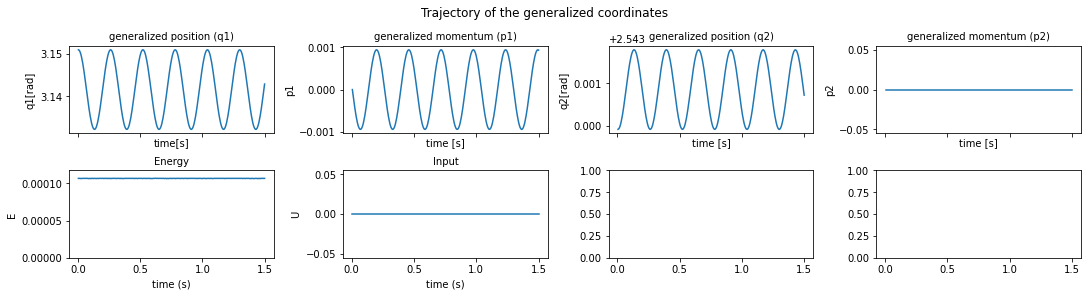

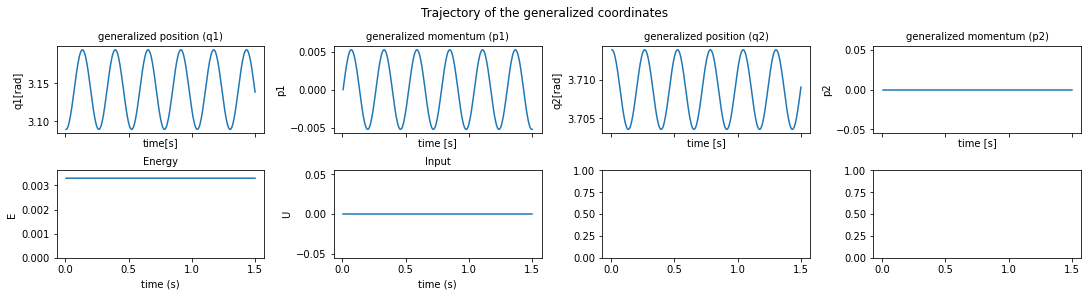

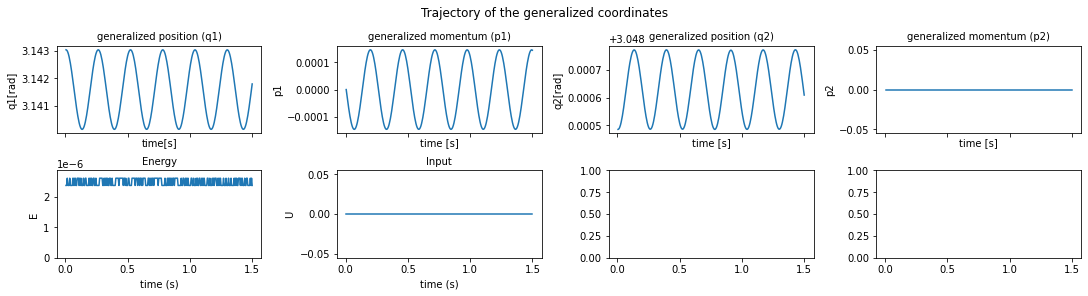

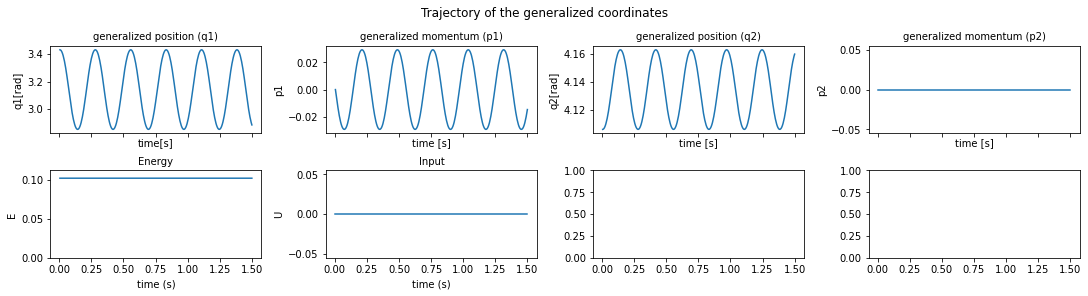

In [62]:
for n in range(10):
  # q1 = x[n,:,0]
  # p1 = x[n,:,1]
  # q2 = x[n,:,2]
  # p2 = x[n,:,3]
  # u = x[n,:,4]
  # G = x[n,:,4:]
  plot_traj_furuta_withinput(t_eval, q1[n,:], p1[n,:], q2[n,:], p2[n,:],energy = energy[n,:] ,input=u[n,:],
                      title = 'Trajectory of the generalized coordinates', coord_type='hamiltonian')

In [59]:
batch_size=10

In [ ]:
train_loader, test_loader = data_loader_furuta(u, G, q1, p1, q2, p2, energy, derivatives, t_eval, batch_size,
                       shuffle = True, proportion = 0.0, coord_type='hamiltonian')

In [364]:
train_loader, test_loader = load_data_device(device, init_method, u_func, g_func, time_steps, num_trajectories, shuffle=False,
                     coord_type='hamiltonian', proportion=0.5, batch_size=10, 
                     Ts = Ts , noise_std = noise_std, C_q1 = C_q1, C_q2 = C_q2, 
                     g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp)

In [365]:
x.shape

torch.Size([1, 300, 9])

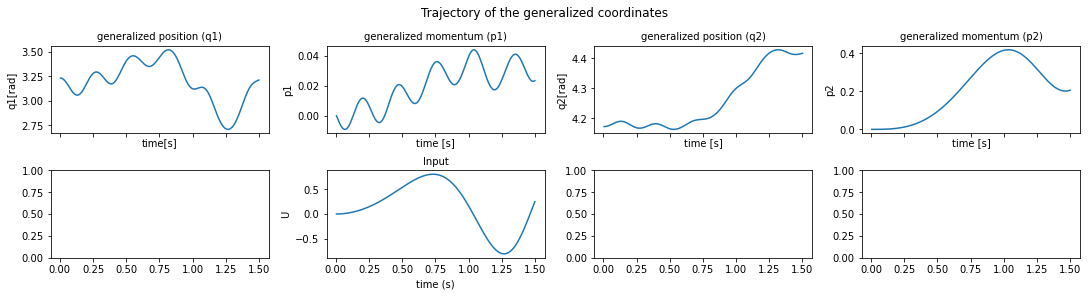

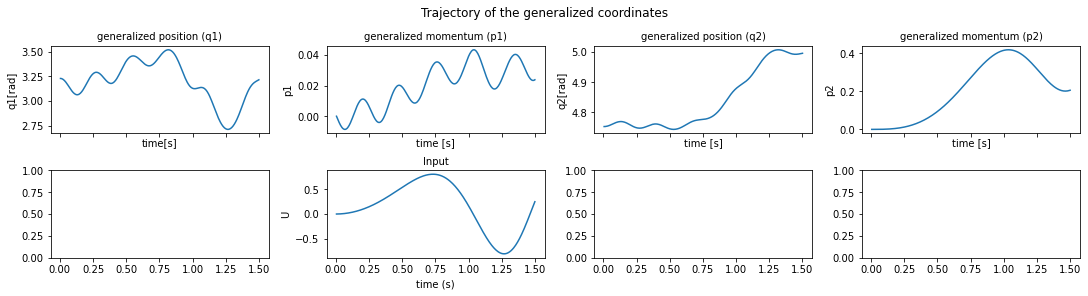

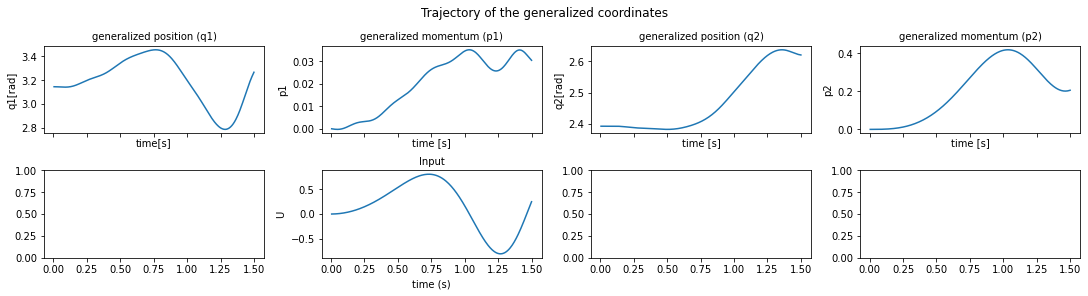

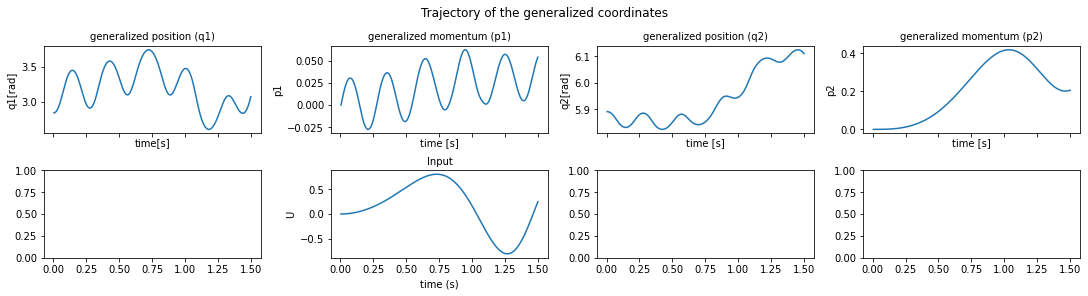

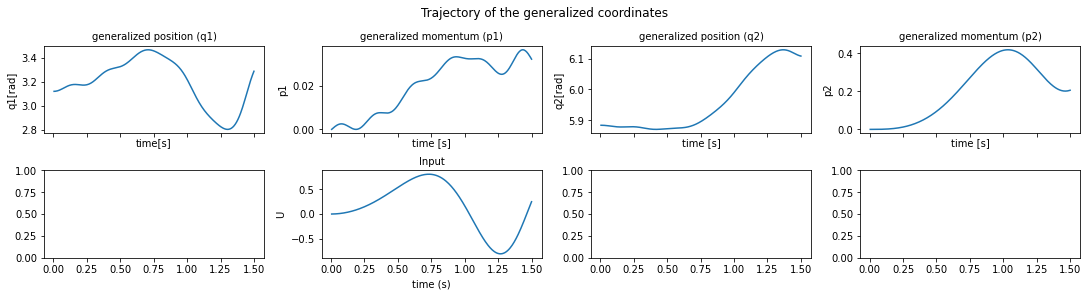

In [366]:
x,t = next(iter(train_loader))
for n in range(5):
  t_eval = t[0,:]
  q1 = x[n,:,0]
  p1 = x[n,:,1]
  q2 = x[n,:,2]
  p2 = x[n,:,3]
  u = x[n,:,4]
  G = x[n,:,4:]
  plot_traj_furuta_withinput(t_eval, q1, p1, q2, p2,input=u,
                      title = 'Trajectory of the generalized coordinates', coord_type='hamiltonian')

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), 1e-4, weight_decay=1e-4)

In [ ]:
torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.3333333333333333, end_factor=1.0, total_iters=5, last_epoch=- 1, verbose=False)

In [ ]:
max_epochs = 100
begin_decay=80
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=max_epochs-begin_decay)
lrs = []

for epoch in range(max_epochs):
    if epoch>begin_decay:
        scheduler.step()
    lrs.append(scheduler.get_last_lr())

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


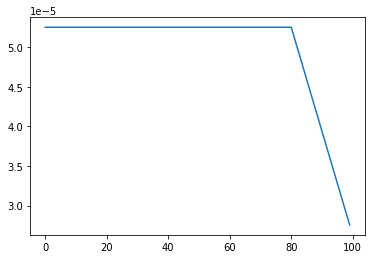

In [ ]:
plt.plot(lrs)



# Generate, load and save the dataset

In [63]:
device = set_device()
Ts, noise_std, C_q1, C_q2, g, Jr, Lr, Mp, Lp = set_furuta_params(which = 'fake') # 'fake'
utype = 'chirp'
u_func = U_FUNC(utype=utype)
u_func.params['T'] = 1.5
u_func.params['f0'] = 0
u_func.params['f1'] = 1.4
u_func.params['scale'] = 0.1
gtype='simple'
g_func = G_FUNC(gtype=gtype)
init_method = 'random_closetopi' # 'random_nozero' # 'random_closetopi'
time_steps= 800
num_trajectories = 1

cpu


In [64]:
device = 'cpu'

In [65]:
train_loader, test_loader = load_data_device(device, init_method, 
                                            u_func, g_func, time_steps, 
                                            shuffle = False, 
                                            num_trajectories = num_trajectories, 
                                            coord_type = 'hamiltonian', 
                                            proportion = 0.0, batch_size = 100, 
                                            Ts=Ts, noise_std=noise_std, C_q1=C_q1, C_q2=C_q2, 
                                            g = g, Jr = Jr, Lr = Lr, Mp = Mp, Lp = Lp)

In [66]:
suffix = 'Ts_{:.3f}_Jr_{:.2f}_Lr_{:.2f}_Mp_{:.2f}_Lp_{:.2f}'.format(Ts, Jr, Lr, Mp, Lp)
suffix = suffix + '_'+ utype+ '_'
print(suffix)

Ts_0.005_Jr_0.00_Lr_0.50_Mp_5.00_Lp_0.10_chirp_


In [67]:
train_loader_path = PATH + 'data/datasets/train_loader_' + suffix + '.pt'
test_loader_path = PATH + 'data/datasets/test_loader_' + suffix + '.pt'

In [68]:
# torch.save(train_loader, train_loader_path)
# if test_loader is not None:
#     torch.save(test_loader, test_loader_path)

In [69]:
# train_loader = torch.load(train_loader_path)
# test_loader = torch.load(test_loader_path)

# Training

In [91]:
# G_net = MLP(input_dim=4, hidden_dim=64, nb_hidden_layers=1, output_dim=2, activation='tanh')
H_net = MLP(input_dim=4, hidden_dim=90, nb_hidden_layers=4, output_dim=1, activation='x+sin(x)^2')
model = Nes_HDNN(u_func=u_func, G_net=g_func, H_net=H_net, device=device)
model.to(device)

Nes_HDNN(
  (H_net): MLP(
    (fc1): Linear(in_features=4, out_features=90, bias=True)
    (hidden_layers): Sequential(
      (0): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
      (1): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
      (2): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
      (3): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
    )
    (fc2): Linear(in_features=90, out_features=1, bias=True)
  )
)

In [92]:
# model = load_model_nes_hdnn(device, utype=None, u_func=None, hidden_dim=90, nb_hidden_layers=4) # load_model(hidden_dim=90, nb_hidden_layers=4)
num_params = count_parameters(model)
print(num_params)

33303


In [93]:
weights = [1.0, 1.0, 10.0, 10.0] # [1.0, 5.0, 10.0, 15.0]

weights_title = ' | weights = ' + str(weights)
print('weights',weights)
horizon_list = [20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,
                200,210,220,230,240,250,260,270,280,290,300]
                #list(range(20,301,10))

switch_steps = [200,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,
                100,100,100,100,50,50,50,50,50,50,50,50,100]
#[100]*len(horizon_list) # [150,150,150,150,150,150,150,150,150,150,150,150,150,150]

print(len(horizon_list))
print(len(switch_steps))
epoch_number = sum(switch_steps)
print(epoch_number)

weights [1.0, 1.0, 10.0, 10.0]
29
29
2600


In [94]:
save_prefix = '{:d}e_w_{:05.1f}_{:05.1f}_{:05.1f}_{:05.1f}_p{:d}k_ts_{:1.3f}__'.format(epoch_number,weights[0],weights[1],weights[2],weights[3],int((num_params-num_params%1000)/1000),Ts)
save_prefix = save_prefix+ '_'+ utype+ '_'
print(save_prefix)

2600e_w_001.0_001.0_010.0_010.0_p33k_ts_0.005___chirp_


horizon length : 20


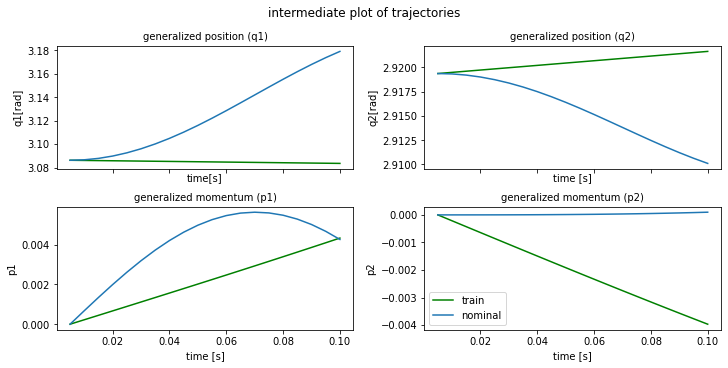

plot time : 1.9917206764221191
epoch    0 | train time 2.25 | train loss 6.977473e-03 
horizon length : 20
epoch    1 | train time 0.18 | train loss 3.720693e-03 
epoch    2 | train time 0.17 | train loss 3.869109e-03 
epoch    3 | train time 0.17 | train loss 2.705822e-03 
epoch    4 | train time 0.18 | train loss 2.355221e-03 
epoch    5 | train time 0.18 | train loss 2.677000e-03 
epoch    6 | train time 0.18 | train loss 2.771966e-03 
epoch    7 | train time 0.17 | train loss 2.421870e-03 
epoch    8 | train time 0.17 | train loss 1.987485e-03 
epoch    9 | train time 0.18 | train loss 1.752607e-03 


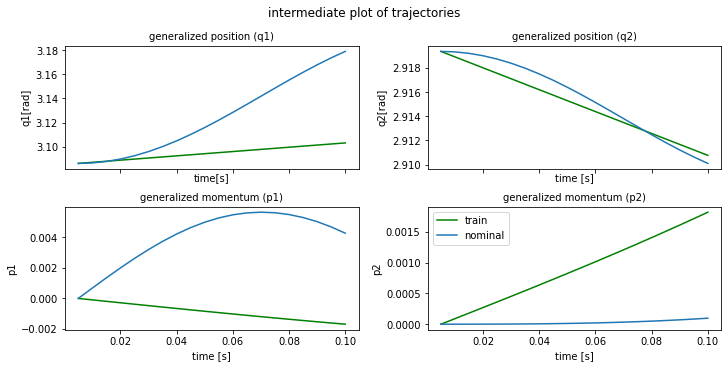

plot time : 1.2704734802246094
epoch   10 | train time 1.48 | train loss 1.735840e-03 
epoch   11 | train time 0.17 | train loss 1.784242e-03 
epoch   12 | train time 0.18 | train loss 1.721584e-03 
epoch   13 | train time 0.18 | train loss 1.486090e-03 
epoch   14 | train time 0.18 | train loss 1.182020e-03 
epoch   15 | train time 0.18 | train loss 9.901833e-04 
epoch   16 | train time 0.18 | train loss 9.603506e-04 
epoch   17 | train time 0.18 | train loss 8.901325e-04 
epoch   18 | train time 0.18 | train loss 6.110183e-04 
epoch   19 | train time 0.18 | train loss 3.285283e-04 


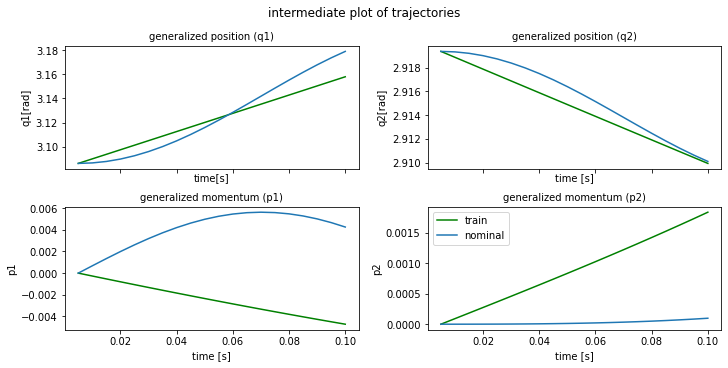

plot time : 1.3320441246032715
epoch   20 | train time 1.52 | train loss 3.730507e-04 
epoch   21 | train time 0.19 | train loss 4.048978e-04 
epoch   22 | train time 0.18 | train loss 2.115699e-04 
epoch   23 | train time 0.17 | train loss 3.603900e-04 
epoch   24 | train time 0.18 | train loss 4.470342e-04 
epoch   25 | train time 0.18 | train loss 2.640632e-04 
epoch   26 | train time 0.19 | train loss 3.059231e-04 
epoch   27 | train time 0.18 | train loss 2.728421e-04 
epoch   28 | train time 0.17 | train loss 1.417773e-04 
epoch   29 | train time 0.17 | train loss 1.786093e-04 


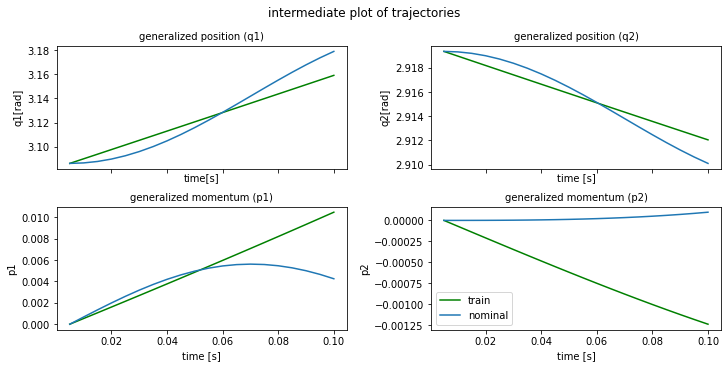

plot time : 1.2810664176940918
epoch   30 | train time 1.48 | train loss 2.589705e-04 
epoch   31 | train time 0.28 | train loss 2.410943e-04 
epoch   32 | train time 0.17 | train loss 2.009453e-04 
epoch   33 | train time 0.17 | train loss 2.224404e-04 
epoch   34 | train time 0.17 | train loss 2.474915e-04 
epoch   35 | train time 0.18 | train loss 2.011680e-04 
epoch   36 | train time 0.17 | train loss 1.482262e-04 
epoch   37 | train time 0.17 | train loss 1.647607e-04 
epoch   38 | train time 0.16 | train loss 1.912192e-04 
epoch   39 | train time 0.17 | train loss 1.642719e-04 


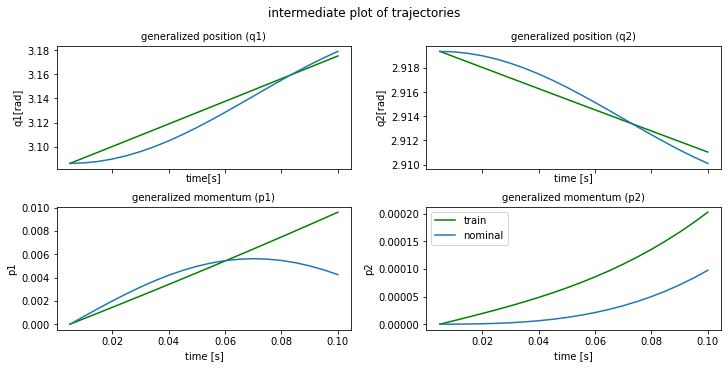

plot time : 1.2978451251983643
epoch   40 | train time 1.47 | train loss 1.489864e-04 
epoch   41 | train time 0.17 | train loss 1.793284e-04 
epoch   42 | train time 0.18 | train loss 1.785936e-04 
epoch   43 | train time 0.18 | train loss 1.454620e-04 
epoch   44 | train time 0.17 | train loss 1.432254e-04 
epoch   45 | train time 0.18 | train loss 1.564430e-04 
epoch   46 | train time 0.17 | train loss 1.477988e-04 
epoch   47 | train time 0.18 | train loss 1.353374e-04 
epoch   48 | train time 0.18 | train loss 1.428900e-04 
epoch   49 | train time 0.19 | train loss 1.542508e-04 


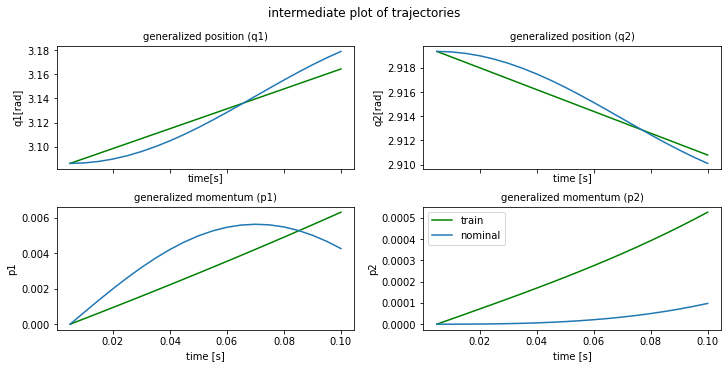

plot time : 1.317518949508667
epoch   50 | train time 1.50 | train loss 1.492399e-04 
epoch   51 | train time 0.18 | train loss 1.394287e-04 
epoch   52 | train time 0.18 | train loss 1.405580e-04 
epoch   53 | train time 0.18 | train loss 1.443924e-04 
epoch   54 | train time 0.18 | train loss 1.390285e-04 
epoch   55 | train time 0.19 | train loss 1.330377e-04 
epoch   56 | train time 0.18 | train loss 1.371375e-04 
epoch   57 | train time 0.18 | train loss 1.416628e-04 
epoch   58 | train time 0.19 | train loss 1.379155e-04 
epoch   59 | train time 0.19 | train loss 1.353428e-04 


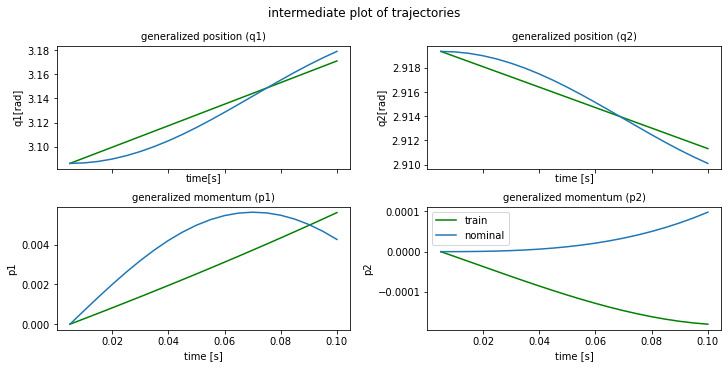

plot time : 1.378880262374878
epoch   60 | train time 1.57 | train loss 1.379223e-04 
epoch   61 | train time 0.19 | train loss 1.370156e-04 
epoch   62 | train time 0.19 | train loss 1.326176e-04 
epoch   63 | train time 0.20 | train loss 1.323953e-04 
epoch   64 | train time 0.19 | train loss 1.348321e-04 
epoch   65 | train time 0.18 | train loss 1.342424e-04 
epoch   66 | train time 0.19 | train loss 1.326383e-04 
epoch   67 | train time 0.20 | train loss 1.336042e-04 
epoch   68 | train time 0.19 | train loss 1.343127e-04 
epoch   69 | train time 0.19 | train loss 1.325076e-04 


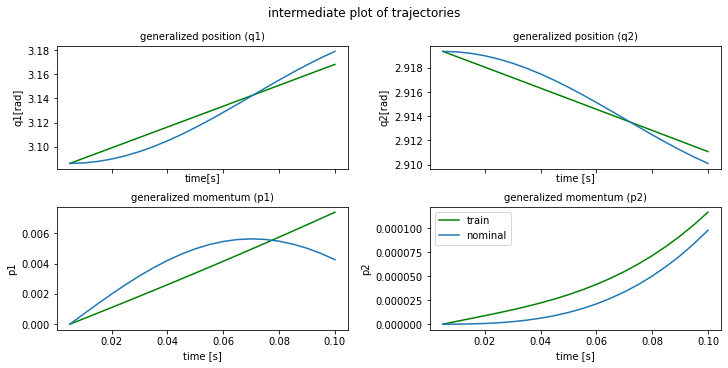

plot time : 1.5117919445037842
epoch   70 | train time 1.73 | train loss 1.312329e-04 
epoch   71 | train time 0.20 | train loss 1.321092e-04 
epoch   72 | train time 0.20 | train loss 1.322702e-04 
epoch   73 | train time 0.18 | train loss 1.313315e-04 
epoch   74 | train time 0.19 | train loss 1.317041e-04 
epoch   75 | train time 0.17 | train loss 1.324194e-04 
epoch   76 | train time 0.19 | train loss 1.316577e-04 
epoch   77 | train time 0.17 | train loss 1.309177e-04 
epoch   78 | train time 0.19 | train loss 1.312547e-04 
epoch   79 | train time 0.18 | train loss 1.310901e-04 


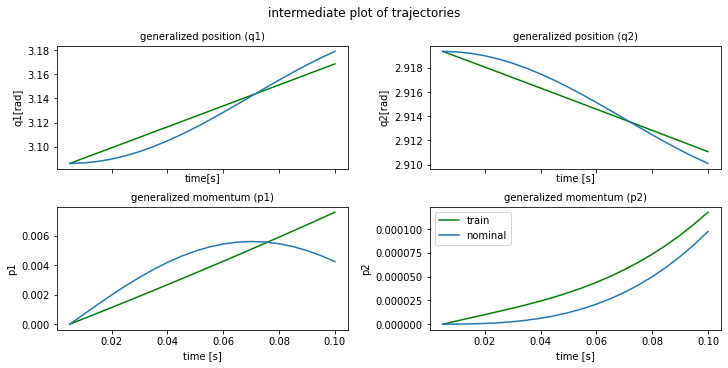

plot time : 1.323991060256958
epoch   80 | train time 1.52 | train loss 1.305005e-04 
epoch   81 | train time 0.18 | train loss 1.306895e-04 
epoch   82 | train time 0.19 | train loss 1.310113e-04 
epoch   83 | train time 0.18 | train loss 1.306266e-04 
epoch   84 | train time 0.18 | train loss 1.303224e-04 
epoch   85 | train time 0.18 | train loss 1.304379e-04 
epoch   86 | train time 0.18 | train loss 1.302354e-04 
epoch   87 | train time 0.18 | train loss 1.298849e-04 
epoch   88 | train time 0.17 | train loss 1.299493e-04 
epoch   89 | train time 0.18 | train loss 1.300562e-04 


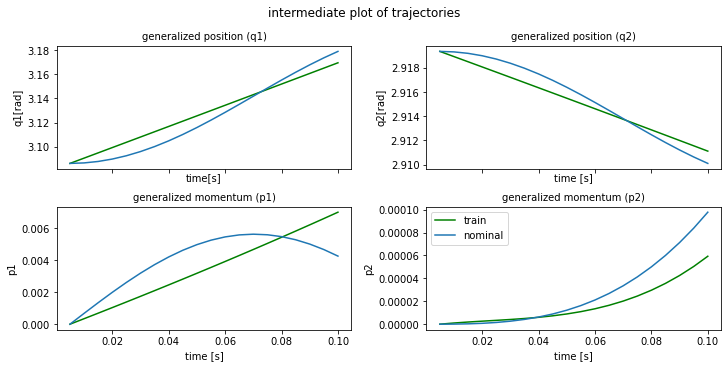

plot time : 1.3217463493347168
epoch   90 | train time 1.51 | train loss 1.298053e-04 
epoch   91 | train time 0.18 | train loss 1.297442e-04 
epoch   92 | train time 0.18 | train loss 1.297644e-04 
epoch   93 | train time 0.18 | train loss 1.295536e-04 
epoch   94 | train time 0.17 | train loss 1.293875e-04 
epoch   95 | train time 0.17 | train loss 1.294179e-04 
epoch   96 | train time 0.17 | train loss 1.293340e-04 
epoch   97 | train time 0.19 | train loss 1.291982e-04 
epoch   98 | train time 0.18 | train loss 1.291919e-04 
epoch   99 | train time 0.18 | train loss 1.291422e-04 


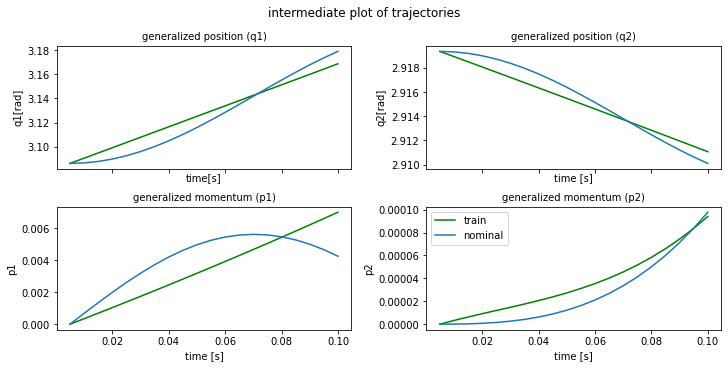

plot time : 1.2913179397583008
epoch  100 | train time 1.48 | train loss 1.289752e-04 
epoch  101 | train time 0.54 | train loss 1.288764e-04 
epoch  102 | train time 0.22 | train loss 1.288414e-04 
epoch  103 | train time 0.20 | train loss 1.286951e-04 
epoch  104 | train time 0.20 | train loss 1.286364e-04 
epoch  105 | train time 0.20 | train loss 1.286016e-04 
epoch  106 | train time 0.19 | train loss 1.285026e-04 
epoch  107 | train time 0.19 | train loss 1.284262e-04 
epoch  108 | train time 0.32 | train loss 1.284020e-04 
epoch  109 | train time 0.20 | train loss 1.283935e-04 


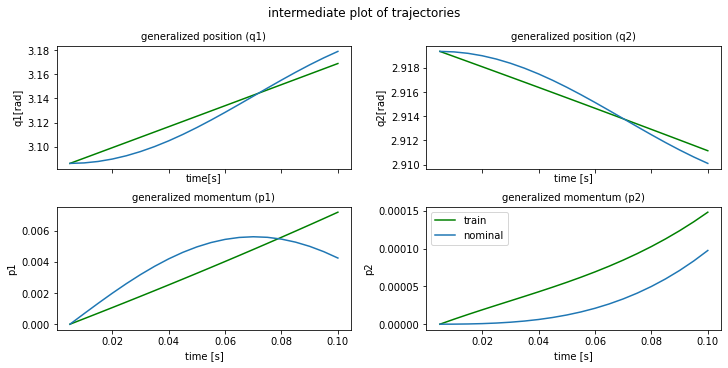

plot time : 1.3665173053741455
epoch  110 | train time 1.57 | train loss 1.285238e-04 
epoch  111 | train time 0.19 | train loss 1.290906e-04 
epoch  112 | train time 0.20 | train loss 1.306702e-04 
epoch  113 | train time 0.23 | train loss 1.350455e-04 
epoch  114 | train time 0.19 | train loss 1.467688e-04 
epoch  115 | train time 0.19 | train loss 1.706058e-04 
epoch  116 | train time 0.19 | train loss 2.049035e-04 
epoch  117 | train time 0.19 | train loss 1.960743e-04 
epoch  118 | train time 0.19 | train loss 1.486469e-04 
epoch  119 | train time 0.19 | train loss 1.305512e-04 


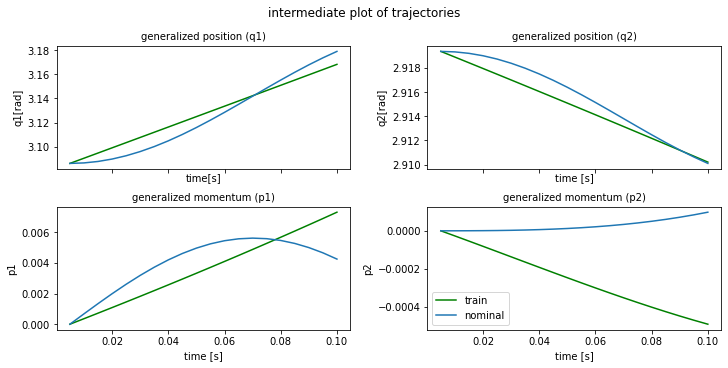

plot time : 1.3593413829803467
epoch  120 | train time 1.55 | train loss 1.637850e-04 
epoch  121 | train time 0.20 | train loss 1.632497e-04 
epoch  122 | train time 0.18 | train loss 1.290704e-04 
epoch  123 | train time 0.19 | train loss 1.449930e-04 
epoch  124 | train time 0.18 | train loss 1.579306e-04 
epoch  125 | train time 0.19 | train loss 1.305102e-04 
epoch  126 | train time 0.18 | train loss 1.374363e-04 
epoch  127 | train time 0.20 | train loss 1.504070e-04 
epoch  128 | train time 0.19 | train loss 1.300854e-04 
epoch  129 | train time 0.19 | train loss 1.347157e-04 


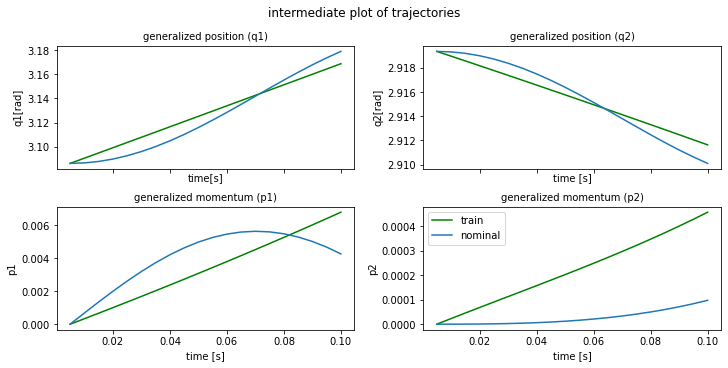

plot time : 1.3038809299468994
epoch  130 | train time 1.49 | train loss 1.435876e-04 
epoch  131 | train time 0.19 | train loss 1.283159e-04 
epoch  132 | train time 0.18 | train loss 1.343215e-04 
epoch  133 | train time 0.18 | train loss 1.380754e-04 
epoch  134 | train time 0.17 | train loss 1.271657e-04 
epoch  135 | train time 0.20 | train loss 1.345631e-04 
epoch  136 | train time 0.18 | train loss 1.335617e-04 
epoch  137 | train time 0.18 | train loss 1.270237e-04 
epoch  138 | train time 0.17 | train loss 1.338661e-04 
epoch  139 | train time 0.17 | train loss 1.302486e-04 


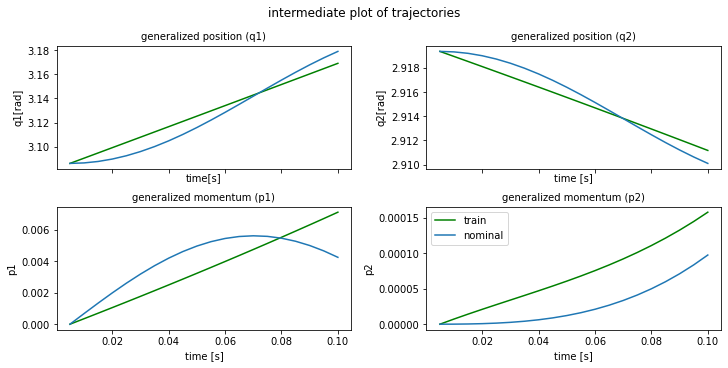

plot time : 1.352447748184204
epoch  140 | train time 1.54 | train loss 1.274122e-04 
epoch  141 | train time 0.18 | train loss 1.324097e-04 
epoch  142 | train time 0.17 | train loss 1.282557e-04 
epoch  143 | train time 0.18 | train loss 1.276649e-04 
epoch  144 | train time 0.17 | train loss 1.307932e-04 
epoch  145 | train time 0.19 | train loss 1.270622e-04 
epoch  146 | train time 0.18 | train loss 1.276951e-04 
epoch  147 | train time 0.18 | train loss 1.293203e-04 
epoch  148 | train time 0.17 | train loss 1.264036e-04 
epoch  149 | train time 0.18 | train loss 1.275014e-04 


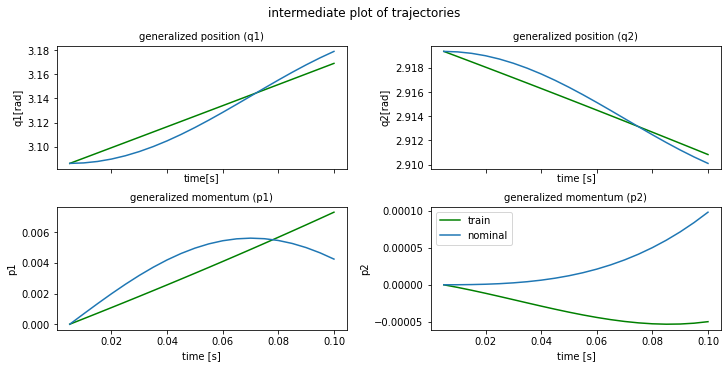

plot time : 1.2311909198760986
epoch  150 | train time 1.43 | train loss 1.280973e-04 
epoch  151 | train time 0.19 | train loss 1.260241e-04 
epoch  152 | train time 0.17 | train loss 1.271261e-04 
epoch  153 | train time 0.18 | train loss 1.272355e-04 
epoch  154 | train time 0.17 | train loss 1.257717e-04 
epoch  155 | train time 0.18 | train loss 1.266554e-04 
epoch  156 | train time 0.18 | train loss 1.266372e-04 
epoch  157 | train time 0.18 | train loss 1.255916e-04 
epoch  158 | train time 0.17 | train loss 1.261611e-04 
epoch  159 | train time 0.19 | train loss 1.261867e-04 


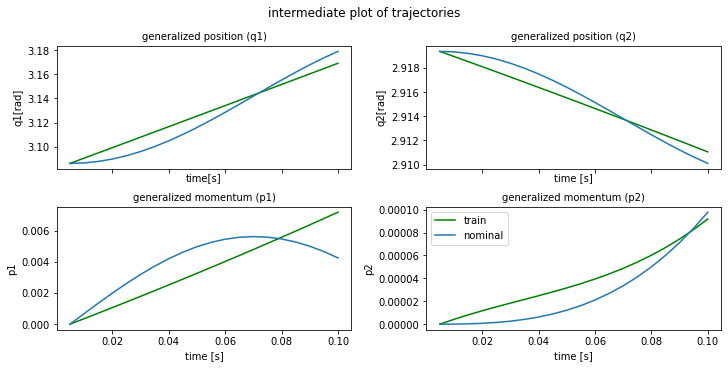

plot time : 1.30422043800354
epoch  160 | train time 1.50 | train loss 1.253580e-04 
epoch  161 | train time 0.18 | train loss 1.256855e-04 
epoch  162 | train time 0.17 | train loss 1.258242e-04 
epoch  163 | train time 0.18 | train loss 1.251921e-04 
epoch  164 | train time 0.18 | train loss 1.252741e-04 
epoch  165 | train time 0.18 | train loss 1.254508e-04 
epoch  166 | train time 0.19 | train loss 1.249867e-04 
epoch  167 | train time 0.21 | train loss 1.248842e-04 
epoch  168 | train time 0.18 | train loss 1.250998e-04 
epoch  169 | train time 0.19 | train loss 1.248544e-04 


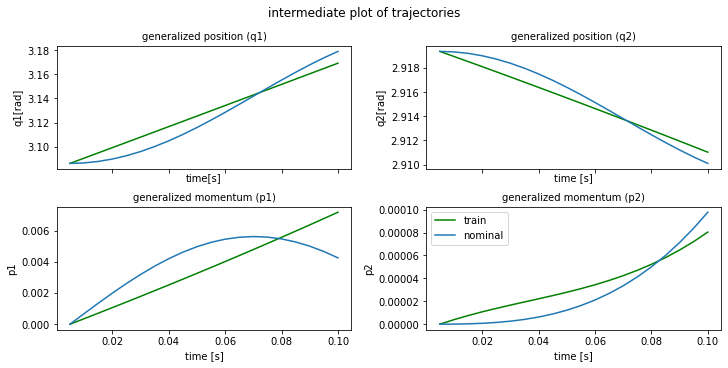

plot time : 1.3148226737976074
epoch  170 | train time 1.53 | train loss 1.245791e-04 
epoch  171 | train time 0.18 | train loss 1.246945e-04 
epoch  172 | train time 0.19 | train loss 1.246497e-04 
epoch  173 | train time 0.19 | train loss 1.243920e-04 
epoch  174 | train time 0.18 | train loss 1.242772e-04 
epoch  175 | train time 0.20 | train loss 1.243245e-04 
epoch  176 | train time 0.18 | train loss 1.241819e-04 
epoch  177 | train time 0.18 | train loss 1.239889e-04 
epoch  178 | train time 0.18 | train loss 1.239563e-04 
epoch  179 | train time 0.19 | train loss 1.239402e-04 


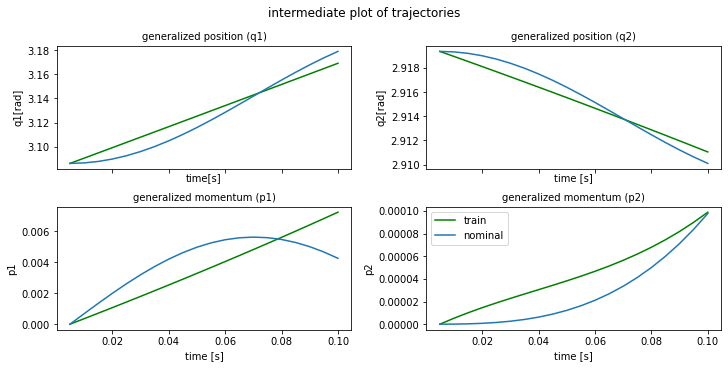

plot time : 1.3969597816467285
epoch  180 | train time 1.60 | train loss 1.237999e-04 
epoch  181 | train time 0.18 | train loss 1.236265e-04 
epoch  182 | train time 0.18 | train loss 1.236036e-04 
epoch  183 | train time 0.19 | train loss 1.235336e-04 
epoch  184 | train time 0.18 | train loss 1.234125e-04 
epoch  185 | train time 0.18 | train loss 1.232827e-04 
epoch  186 | train time 0.16 | train loss 1.232048e-04 
epoch  187 | train time 0.19 | train loss 1.231346e-04 
epoch  188 | train time 0.18 | train loss 1.230381e-04 
epoch  189 | train time 0.18 | train loss 1.229185e-04 


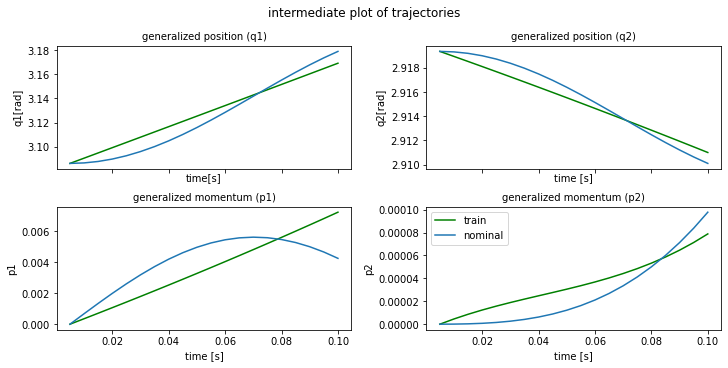

plot time : 1.2932515144348145
epoch  190 | train time 1.48 | train loss 1.228067e-04 
epoch  191 | train time 0.18 | train loss 1.227085e-04 
epoch  192 | train time 0.17 | train loss 1.226347e-04 
epoch  193 | train time 0.18 | train loss 1.225482e-04 
epoch  194 | train time 0.17 | train loss 1.224496e-04 
epoch  195 | train time 0.18 | train loss 1.223291e-04 
epoch  196 | train time 0.17 | train loss 1.221976e-04 
epoch  197 | train time 0.18 | train loss 1.220998e-04 
epoch  198 | train time 0.17 | train loss 1.219966e-04 
epoch  199 | train time 0.18 | train loss 1.219147e-04 


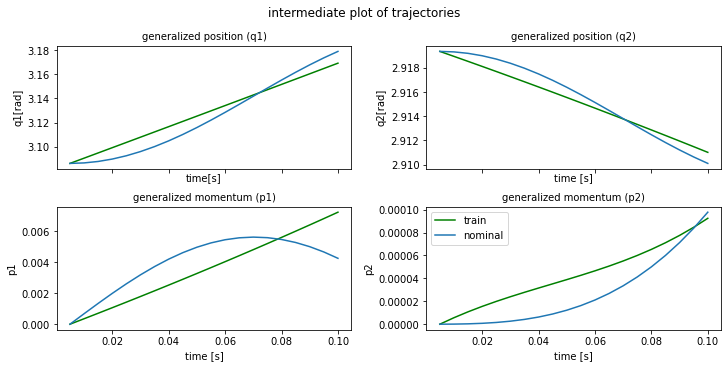

plot time : 1.2617695331573486
epoch  200 | train time 1.46 | train loss 1.218252e-04 
horizon length : 30
epoch  201 | train time 0.28 | train loss 1.824170e-04 
epoch  202 | train time 0.27 | train loss 4.802514e-04 
epoch  203 | train time 0.28 | train loss 8.365556e-03 
epoch  204 | train time 0.26 | train loss 7.948886e-03 
epoch  205 | train time 0.27 | train loss 6.174013e-03 
epoch  206 | train time 0.26 | train loss 2.938823e-03 
epoch  207 | train time 0.27 | train loss 3.243903e-03 
epoch  208 | train time 0.28 | train loss 3.471739e-03 
epoch  209 | train time 0.27 | train loss 2.838115e-03 


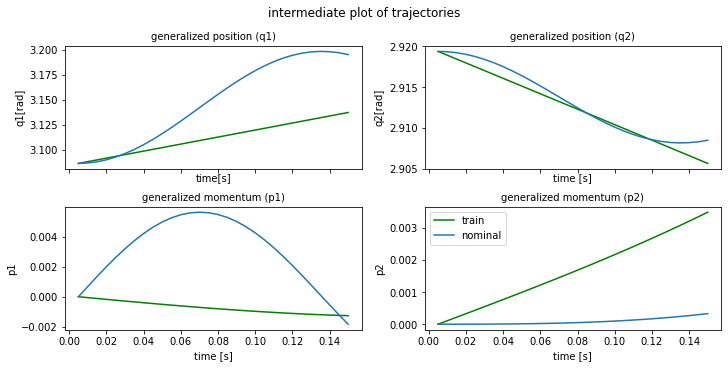

plot time : 1.3892924785614014
epoch  210 | train time 1.67 | train loss 2.465098e-03 
epoch  211 | train time 0.27 | train loss 2.449097e-03 
epoch  212 | train time 0.27 | train loss 1.767961e-03 
epoch  213 | train time 0.27 | train loss 9.715171e-04 
epoch  214 | train time 0.27 | train loss 1.187185e-03 
epoch  215 | train time 0.27 | train loss 6.507151e-04 
epoch  216 | train time 0.27 | train loss 3.832967e-04 
epoch  217 | train time 0.28 | train loss 9.727804e-04 
epoch  218 | train time 0.27 | train loss 4.237493e-04 
epoch  219 | train time 0.27 | train loss 7.791900e-04 


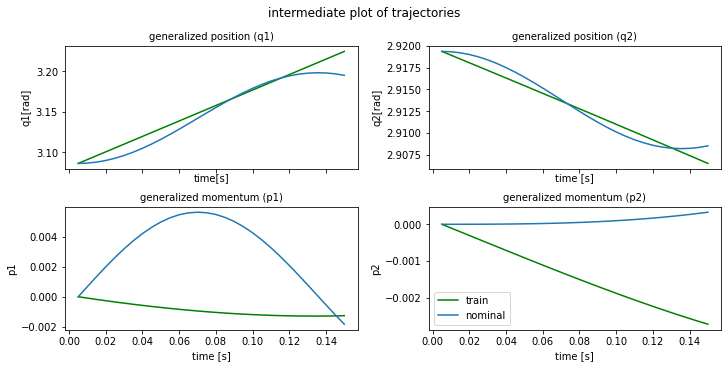

plot time : 1.3031463623046875
epoch  220 | train time 1.59 | train loss 5.289011e-04 
epoch  221 | train time 0.29 | train loss 2.107156e-04 
epoch  222 | train time 0.28 | train loss 3.543366e-04 
epoch  223 | train time 0.28 | train loss 5.003894e-04 
epoch  224 | train time 0.28 | train loss 3.755995e-04 
epoch  225 | train time 0.29 | train loss 3.439365e-04 
epoch  226 | train time 0.31 | train loss 4.201708e-04 
epoch  227 | train time 0.28 | train loss 3.936213e-04 
epoch  228 | train time 0.28 | train loss 2.803756e-04 
epoch  229 | train time 0.28 | train loss 1.702214e-04 


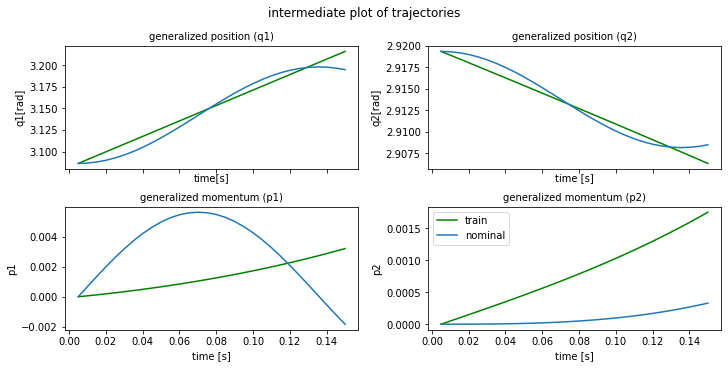

plot time : 1.369114875793457
epoch  230 | train time 1.66 | train loss 2.334430e-04 
epoch  231 | train time 0.28 | train loss 2.897505e-04 
epoch  232 | train time 0.28 | train loss 2.275548e-04 
epoch  233 | train time 0.29 | train loss 2.343800e-04 
epoch  234 | train time 0.28 | train loss 2.652920e-04 
epoch  235 | train time 0.28 | train loss 2.276574e-04 
epoch  236 | train time 0.30 | train loss 1.588622e-04 
epoch  237 | train time 0.29 | train loss 1.813349e-04 
epoch  238 | train time 0.49 | train loss 2.137071e-04 
epoch  239 | train time 0.40 | train loss 2.076282e-04 


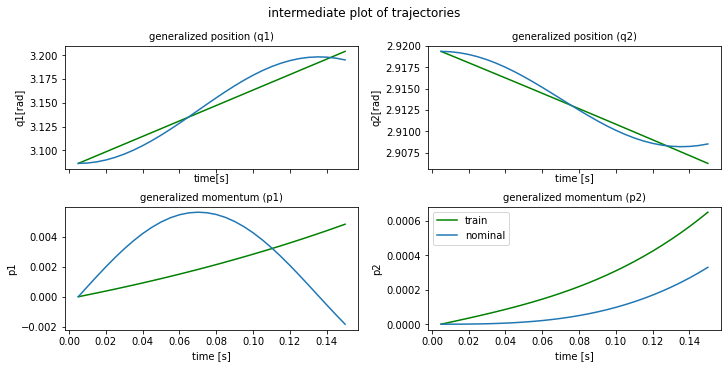

plot time : 2.0463287830352783
epoch  240 | train time 2.34 | train loss 1.909694e-04 
epoch  241 | train time 0.26 | train loss 1.889299e-04 
epoch  242 | train time 0.28 | train loss 2.016339e-04 
epoch  243 | train time 0.27 | train loss 1.893334e-04 
epoch  244 | train time 0.27 | train loss 1.619073e-04 
epoch  245 | train time 0.28 | train loss 1.608440e-04 
epoch  246 | train time 0.29 | train loss 1.761711e-04 
epoch  247 | train time 0.29 | train loss 1.822028e-04 
epoch  248 | train time 0.28 | train loss 1.704135e-04 
epoch  249 | train time 0.30 | train loss 1.672119e-04 


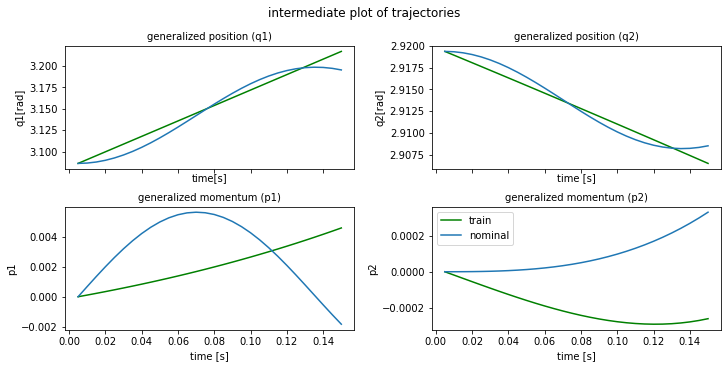

plot time : 1.3354403972625732
epoch  250 | train time 1.64 | train loss 1.741017e-04 
epoch  251 | train time 0.29 | train loss 1.675638e-04 
epoch  252 | train time 0.29 | train loss 1.585291e-04 
epoch  253 | train time 0.28 | train loss 1.579987e-04 
epoch  254 | train time 0.28 | train loss 1.652486e-04 
epoch  255 | train time 0.29 | train loss 1.680823e-04 
epoch  256 | train time 0.30 | train loss 1.625633e-04 
epoch  257 | train time 0.29 | train loss 1.605664e-04 
epoch  258 | train time 0.29 | train loss 1.619456e-04 
epoch  259 | train time 0.31 | train loss 1.613337e-04 


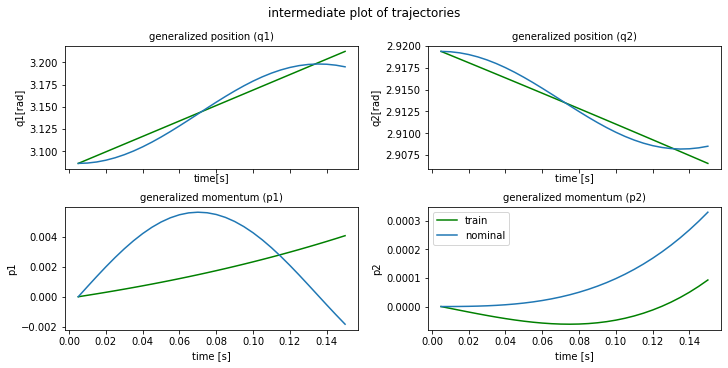

plot time : 1.3111777305603027
epoch  260 | train time 1.59 | train loss 1.580189e-04 
epoch  261 | train time 0.28 | train loss 1.559419e-04 
epoch  262 | train time 0.28 | train loss 1.592236e-04 
epoch  263 | train time 0.28 | train loss 1.611640e-04 
epoch  264 | train time 0.29 | train loss 1.590959e-04 
epoch  265 | train time 0.30 | train loss 1.574469e-04 
epoch  266 | train time 0.28 | train loss 1.576136e-04 
epoch  267 | train time 0.29 | train loss 1.581294e-04 
epoch  268 | train time 0.31 | train loss 1.567024e-04 
epoch  269 | train time 0.40 | train loss 1.558751e-04 


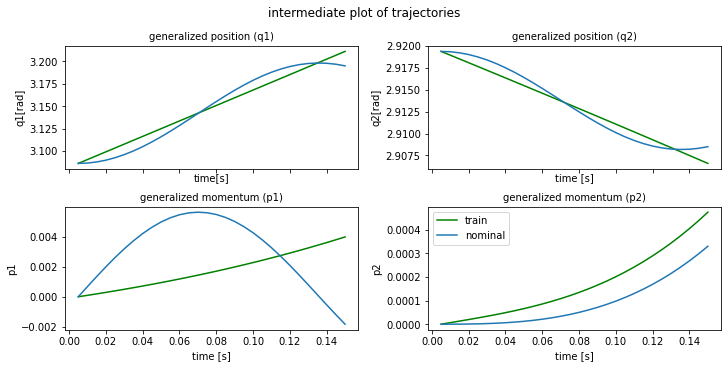

plot time : 1.381446123123169
epoch  270 | train time 1.67 | train loss 1.571718e-04 
epoch  271 | train time 0.29 | train loss 1.579370e-04 
epoch  272 | train time 0.30 | train loss 1.573750e-04 
epoch  273 | train time 0.28 | train loss 1.562618e-04 
epoch  274 | train time 0.30 | train loss 1.562003e-04 
epoch  275 | train time 0.28 | train loss 1.566287e-04 
epoch  276 | train time 0.28 | train loss 1.561515e-04 
epoch  277 | train time 0.29 | train loss 1.558105e-04 
epoch  278 | train time 0.30 | train loss 1.561246e-04 
epoch  279 | train time 0.29 | train loss 1.565858e-04 


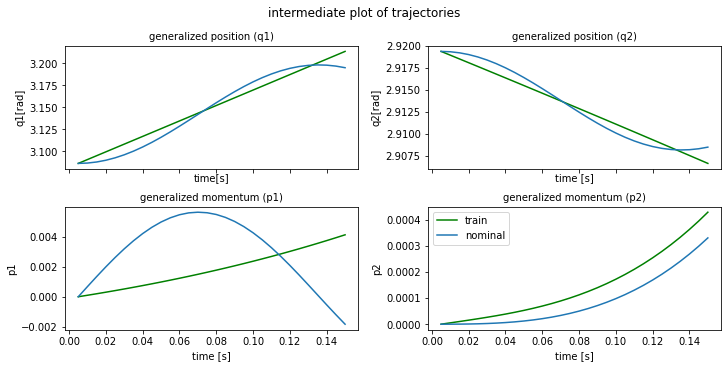

plot time : 1.3373372554779053
epoch  280 | train time 1.64 | train loss 1.563814e-04 
epoch  281 | train time 0.29 | train loss 1.557658e-04 
epoch  282 | train time 0.28 | train loss 1.557706e-04 
epoch  283 | train time 0.28 | train loss 1.559284e-04 
epoch  284 | train time 0.31 | train loss 1.558453e-04 
epoch  285 | train time 0.28 | train loss 1.556906e-04 
epoch  286 | train time 0.29 | train loss 1.557670e-04 
epoch  287 | train time 0.29 | train loss 1.560140e-04 
epoch  288 | train time 0.27 | train loss 1.558632e-04 
epoch  289 | train time 0.28 | train loss 1.556192e-04 


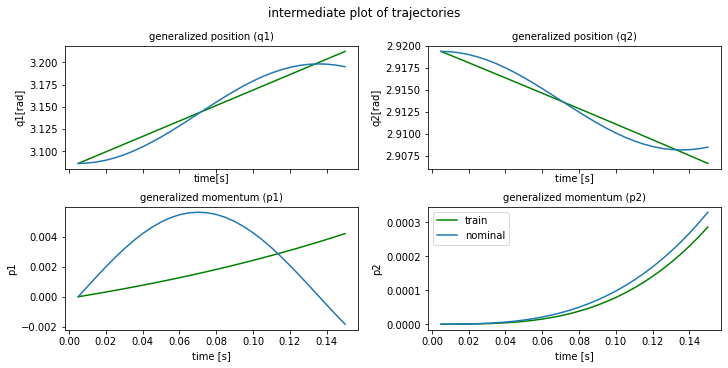

plot time : 1.3887724876403809
epoch  290 | train time 1.66 | train loss 1.555956e-04 
epoch  291 | train time 0.27 | train loss 1.556832e-04 
epoch  292 | train time 0.27 | train loss 1.556877e-04 
epoch  293 | train time 0.28 | train loss 1.555933e-04 
epoch  294 | train time 0.28 | train loss 1.556259e-04 
epoch  295 | train time 0.28 | train loss 1.557162e-04 
epoch  296 | train time 0.30 | train loss 1.556564e-04 
epoch  297 | train time 0.28 | train loss 1.555491e-04 
epoch  298 | train time 0.28 | train loss 1.555333e-04 
epoch  299 | train time 0.28 | train loss 1.555820e-04 


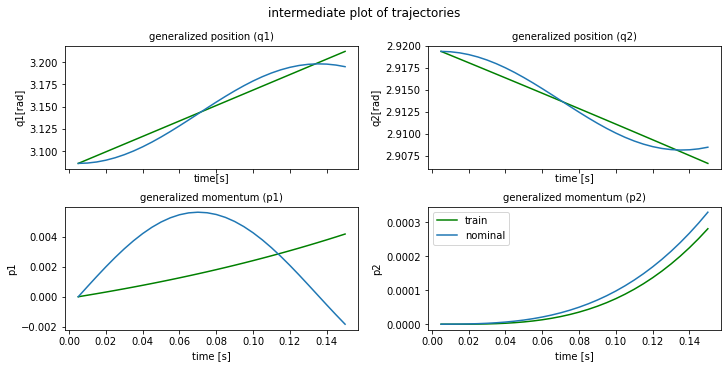

plot time : 1.3053879737854004
epoch  300 | train time 1.60 | train loss 1.556006e-04 
horizon length : 40
epoch  301 | train time 0.37 | train loss 2.698075e-03 
epoch  302 | train time 0.35 | train loss 2.542388e-03 
epoch  303 | train time 0.38 | train loss 2.120689e-03 
epoch  304 | train time 0.37 | train loss 1.405494e-03 
epoch  305 | train time 0.38 | train loss 2.123996e-03 
epoch  306 | train time 0.37 | train loss 1.919275e-03 
epoch  307 | train time 0.37 | train loss 1.885004e-03 
epoch  308 | train time 0.37 | train loss 2.131895e-03 
epoch  309 | train time 0.37 | train loss 2.015848e-03 


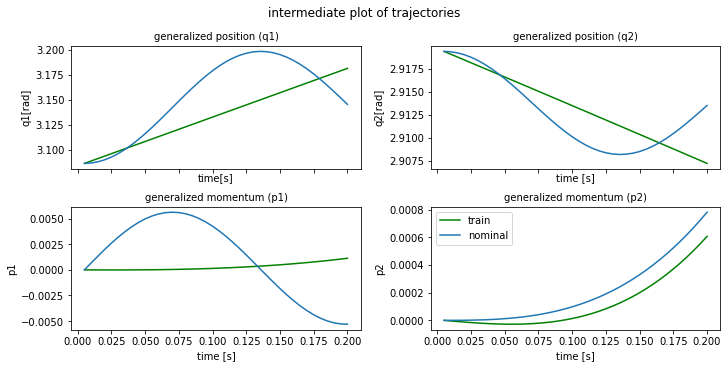

plot time : 1.4351387023925781
epoch  310 | train time 1.82 | train loss 1.645146e-03 
epoch  311 | train time 0.38 | train loss 1.521810e-03 
epoch  312 | train time 0.40 | train loss 1.582488e-03 
epoch  313 | train time 0.37 | train loss 1.401760e-03 
epoch  314 | train time 0.38 | train loss 1.408948e-03 
epoch  315 | train time 0.39 | train loss 1.635234e-03 
epoch  316 | train time 0.38 | train loss 1.561763e-03 
epoch  317 | train time 0.51 | train loss 1.456594e-03 
epoch  318 | train time 0.39 | train loss 1.528429e-03 
epoch  319 | train time 0.39 | train loss 1.424967e-03 


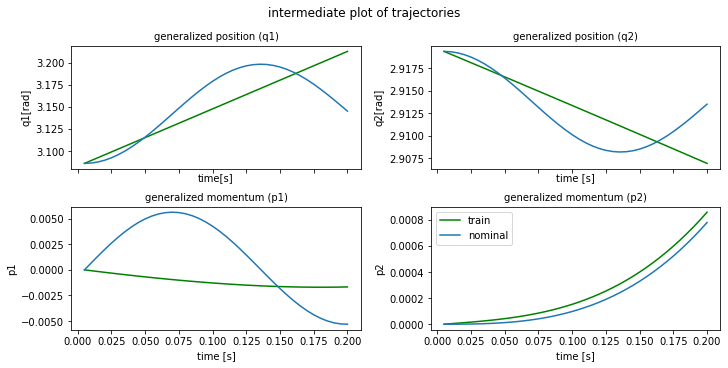

plot time : 1.453622817993164
epoch  320 | train time 1.85 | train loss 1.329671e-03 
epoch  321 | train time 0.37 | train loss 1.399268e-03 
epoch  322 | train time 0.40 | train loss 1.439594e-03 
epoch  323 | train time 0.38 | train loss 1.396172e-03 
epoch  324 | train time 0.41 | train loss 1.385586e-03 
epoch  325 | train time 0.40 | train loss 1.432758e-03 
epoch  326 | train time 0.38 | train loss 1.426884e-03 
epoch  327 | train time 0.40 | train loss 1.367224e-03 
epoch  328 | train time 0.37 | train loss 1.352557e-03 
epoch  329 | train time 0.36 | train loss 1.371237e-03 


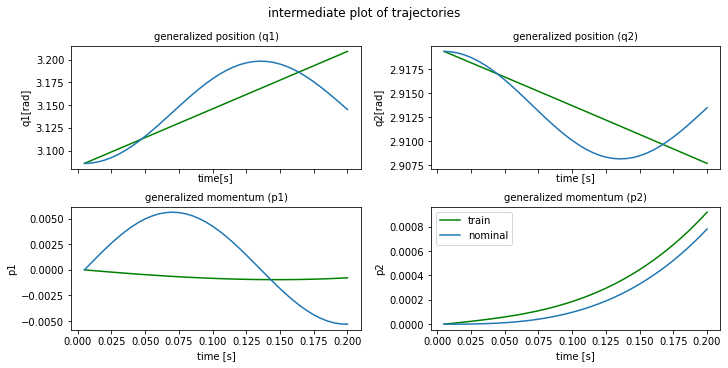

plot time : 1.3735792636871338
epoch  330 | train time 1.77 | train loss 1.354913e-03 
epoch  331 | train time 0.38 | train loss 1.326712e-03 
epoch  332 | train time 0.37 | train loss 1.345215e-03 
epoch  333 | train time 0.36 | train loss 1.368331e-03 
epoch  334 | train time 0.38 | train loss 1.350287e-03 
epoch  335 | train time 0.37 | train loss 1.341585e-03 
epoch  336 | train time 0.38 | train loss 1.352269e-03 
epoch  337 | train time 0.38 | train loss 1.342173e-03 
epoch  338 | train time 0.37 | train loss 1.322669e-03 
epoch  339 | train time 0.37 | train loss 1.325387e-03 


KeyboardInterrupt: ignored

In [95]:
stats = train(model = model, 
              Ts = Ts, 
              train_loader = train_loader, 
              test_loader = test_loader, 
              w=torch.tensor(weights, device=device),
              grad_clip = True,
              lr_schedule = False,
              begin_decay = 1500, 
              epoch_number = epoch_number, 
              alternating = False,
              horizon = False, 
              horizon_type = 'auto', 
              horizon_list = horizon_list, 
              switch_steps = switch_steps, 
              epochs = epoch_number, 
              loss_type = 'L2weighted2') # L2normalizedfixed3 0.5

# Saving model and stats

In [ ]:
stats_path = PATH+'data/stats/'+save_prefix+'stats.txt'

In [ ]:
# save the stats
save_stats(PATH, stats, stats_path)

In [ ]:
# loads the stats 
stats = read_dict(PATH, stats_path)

In [ ]:
model_name = 'models/'+save_prefix+'model_test'

In [ ]:
# save model to disk
model_name = 'data/models/'+save_prefix+'model_test'
torch.save(model.state_dict(), PATH+model_name)

In [ ]:
# load the model from disk
model = load_model_nes_hdnn(device,utype=utype, u_func=u_func, hidden_dim=90, nb_hidden_layers=4) # load_model(hidden_dim=90, nb_hidden_layers=4)
#load_model(device, hidden_dim=90, nb_hidden_layers=4)
model.load_state_dict(torch.load(PATH+model_name))
model.eval()

Nes_HDNN(
  (H_net): MLP(
    (fc1): Linear(in_features=4, out_features=90, bias=True)
    (hidden_layers): Sequential(
      (0): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
      (1): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
      (2): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
      (3): hidden_Layer(
        (fc): Linear(in_features=90, out_features=90, bias=True)
      )
    )
    (fc2): Linear(in_features=90, out_features=1, bias=True)
  )
  (G_net): MLP(
    (fc1): Linear(in_features=4, out_features=64, bias=True)
    (hidden_layers): Sequential(
      (0): hidden_Layer(
        (fc): Linear(in_features=64, out_features=64, bias=True)
      )
    )
    (fc2): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [ ]:
print(model.C2_dissip)
print(model.C1_dissip)

Parameter containing:
tensor([0.1414], requires_grad=True)
Parameter containing:
tensor([0.1414], requires_grad=True)


# Plots of results

In [ ]:
horizon_steps = []
horizon_steps.append(0)
for i, number in enumerate(switch_steps) :
  horizon_steps.append(horizon_steps[i] +number) 
horizon_steps = horizon_steps[1:-1]
# horizon_steps

In [ ]:
loss_train = stats['train_loss']
loss_test = stats['test_loss']
epochs = np.arange(len(loss_train))
train_test_loss_plot(loss_train, loss_test, epochs, file_path=PATH+'data/img/'+save_prefix+'LOSS_train_test_1.png', 
                     title='train and test loss per epoch'+ weights_title, horizons= False )

train_test_loss_plot(loss_train, loss_test, epochs, file_path=PATH+'data/img/'+save_prefix+'LOSS_train_test_2.png', 
                     title='train and test loss per epoch'+ weights_title, horizons= horizon_list[:-1], horizon_steps = horizon_steps )

In [ ]:
time_steps

NameError: ignored

In [ ]:
torch.tensor([1]).device

device(type='cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
time_steo=5
torch.linspace(1, 5, 5,device=device) * torch.tensor([2],device=device)

tensor([ 2.,  4.,  6.,  8., 10.], device='cuda:0')

In [ ]:
n=10
plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                     title = 'Train set trajectories'+ weights_title, file_path=PATH+'data/img/'+save_prefix+'TRAJECTORIES_train_set'+str(n)+'.png')

TypeError: ignored

In [ ]:
n=20
plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=train_loader, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                     title = 'Train set trajectories'+ weights_title, file_path=PATH+'data/img/'+save_prefix+'TRAJECTORIES_train_set'+str(n)+'.png')

In [ ]:
n = 10 

plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=test_loader, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                     title = 'Test set trajectories'+ weights_title, file_path=PATH+'data/img/'+save_prefix+'TRAJECTORIES_test_set'+str(n)+'.png')

In [ ]:
n = 7
plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=test_loader, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                     title = 'Test set trajectories'+ weights_title, file_path=PATH+'data/img/'+save_prefix+'TRAJECTORIES_test_set'+str(n)+'.png')

In [ ]:
n = 12
plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=test_loader, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                     title = 'Test set trajectories'+ weights_title, file_path=None)#PATH+'data/img/'+save_prefix+'TRAJECTORIES_test_set'+str(n)+'.png')

In [ ]:
test_loader_3, _ , _ = load_data_device(device, utype, gtype, init_method=init_method,u_func=u_func, g_func=g_func, time_steps=100, num_trajectories=2,  coord_type='hamiltonian', proportion=0.0, batch_size=1,
                                        noise_std=noise_std, Ts=Ts,C_q1= C_q1, C_q2= C_q2, g= g, Jr= Jr, Lr= Lr, Mp= Mp, Lp= Lp)


In [ ]:
test_loader_path_3 = PATH + 'data/datasets/test_loader_longer_3' + suffix + '.pt'

In [ ]:
torch.save(test_loader_3, test_loader_path_3)

In [ ]:
test_loader_3 = torch.load(test_loader_path_3)

In [ ]:
plot_longer_horizon_furuta(device, model, u_func, g_func, utype, gtype, test_loader=test_loader_3,t1=0,t2=2000, C_q1= C_q1, C_q2= C_q2, g= g, Jr= Jr, Lr= Lr, Mp= Mp, Lp= Lp, title = 'Trajectory after longer horizon'+ weights_title,
                           file_path=PATH+'img/'+save_prefix+'TRAJ_longer_horizon1.png')

In [ ]:
plot_longer_horizon_furuta(device, model, u_func, g_func, utype, gtype, test_loader=test_loader_3,t1=2000,t2=10000, C_q1= C_q1, C_q2= C_q2, g= g, Jr= Jr, Lr= Lr, Mp= Mp, Lp= Lp, title = 'Trajectory after longer horizon'+ weights_title,
                           file_path=PATH+'img/'+save_prefix+'TRAJ_longer_horizon2.png')

In [ ]:
n = 0
plot_furuta_hat_nom(device, model, u_func, g_func, utype, gtype, data_loader_t=test_loader_3, t_max=300, n=n, C_q1=C_q1, C_q2=C_q2, g=g, Jr=Jr, Lr=Lr, Mp=Mp, Lp=Lp,
                     title = 'Test set trajectories'+ weights_title, file_path=PATH+'img/'+save_prefix+'TRAJECTORIES_test_set_longer'+str(n)+'.png')